# Building Univariate Time Series Models


Matplotlib -> 3.5.2
pandas -> 1.4.4   
numpy -> 1.22.3
scipy -> 1.7.3
statsmodels -> 0.13.2
sklearn -> 1.1.3

(59, 1)
(168, 1)


<AxesSubplot:title={'center':'Monthly Milk Production'}, xlabel='month'>

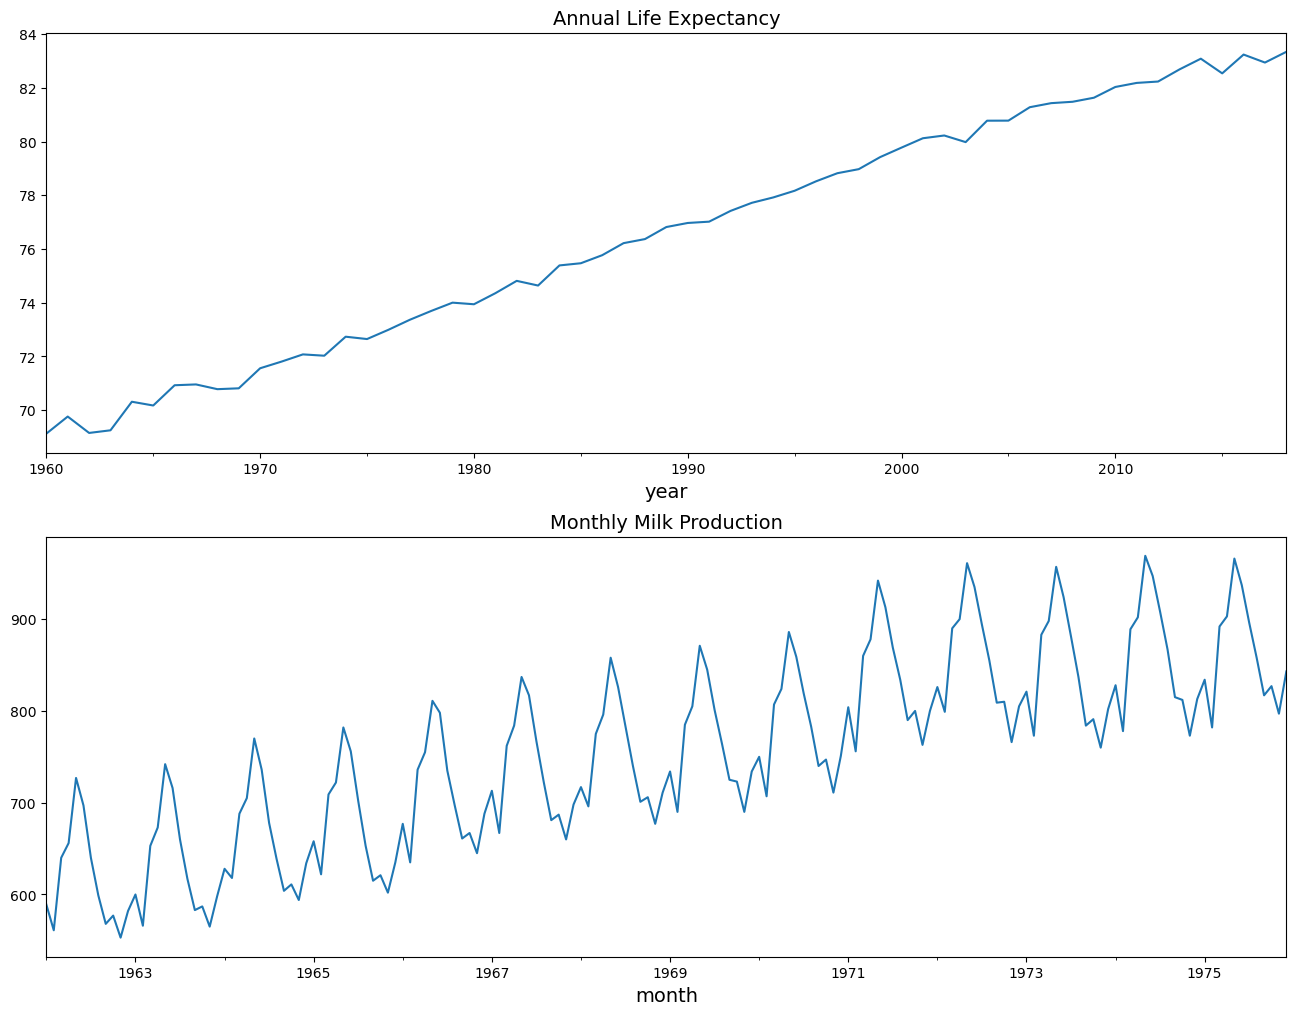

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import scipy
import sklearn
import statsmodels as sm
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path

warnings.filterwarnings('ignore')

###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
sklearn -> {sklearn.__version__}
''')


life_file = r'./CodeAndDatasets/datasets/Ch10/life_expectancy_birth.csv'
milk_file = r'./CodeAndDatasets/datasets/Ch10/milk_production.csv'

life = pd.read_csv(life_file, index_col='year', parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, index_col='month', parse_dates=True)

print(life.shape)
print(milk.shape)

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy', 
                        legend=False, ax=ax[0])  # has only trend
milk.plot(title='Monthly Milk Production', 
                        legend=False, ax=ax[1]) # has both trend and seasonality

# plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [14]:
## function to split the data based on the split factor

def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

## Check the assumptions for the models
# check for stationarity using adfuller test
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

## get the best model
   ## you may choose the evaluation (the c parameter) to be based on 
   # the Root Mean Squared Percentage Error (RMSPE), 
   # Root Mean Square Error (RMSE), 
   # Mean Square Error (MSE), 
   # Akaike's Information Criteria (AIC), 
   # Corrected Akaike's Information Criteria (AICc), and 
   # Bayesian Information Criteria (BIC), 
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

# combinator utility function

def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

train: 143 , test: 25
train: 50 , test: 9


## Plotting ACF and PACF

ACF and PACF plots are used to determine the orders (parameters) for some of the models.

When building statitical forecasting models such as **AR, MA, ARMA, ARIMA, SARIMA** we need to determine the type of time series model that is most suitable for timeseries data. these parameters are called orders.

More specifically, these are called the lag orders for the autoregressive (AR) or moving average (MA) components.

for example, an Autoregressive Moving Average (ARMA) model can be written as ARMA(p, q), where p is the autoregressive order or AR(p) component, 
and q is the moving average order or MA(q) component. Hence, an ARMA model 
combines an AR(p) and an MA(q) model.

The core idea behind these models is built on the assumption that the current value of a particular variable, 𝑥𝑥, can be estimated from past values of itself. 

For example, in an autoregressive model of order p or AR(p), we assume that the current value, 𝑥𝑡, at time 𝑡𝑡 can be estimated from its past values (𝑥𝑡−1, 𝑥𝑡−2, … , 𝑥𝑡−𝑝) up to p, where p determines how many lags (steps back) we need to go. If 𝑝 = 2, this means we must use two previous 
periods (𝑥𝑡−1, 𝑥𝑡−2 ) to predict 𝑥𝑡.

How do I find the significant lag values for AR and MA models?
ACF (ACF for MA order) and PACF (PACF for AR order) plots (a.k.a correlograms) used to find significant lag values (p, q). Both plots have -1 to 1 on y-axis and size of lag on x-axis. A significant lag is any lag that goes outside the shaded confidence interval

The main difference between ARMA and ARIMA models is that ARMA model assumes a stationary process, while ARIMA(p, d, q) doesnt since it handles differencing. 

<AxesSubplot:xlabel='year'>

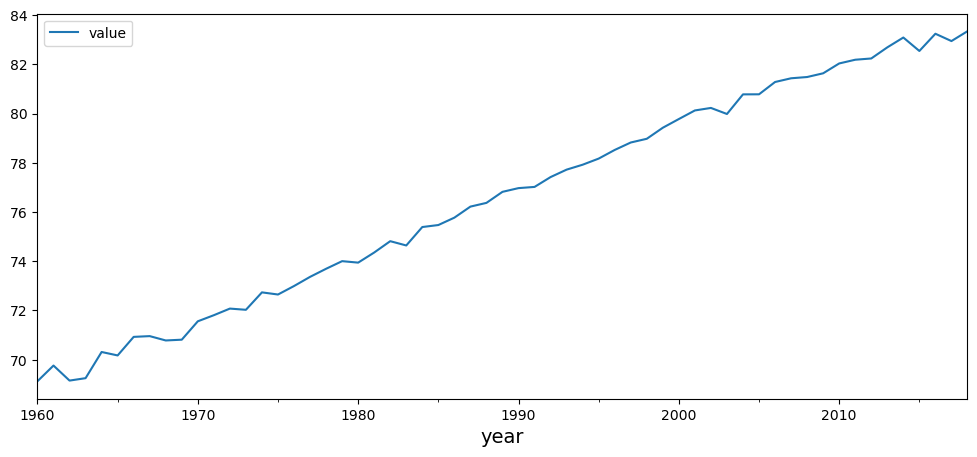

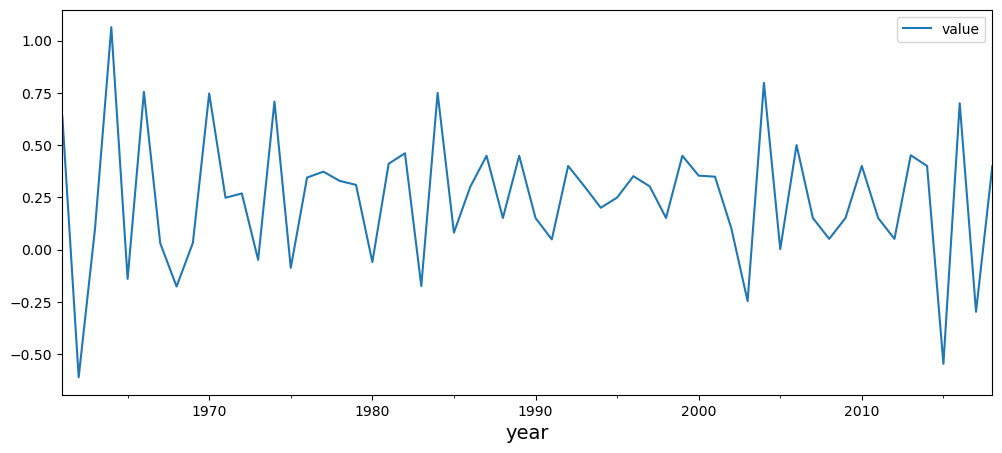

In [15]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna() # first order differencing for de-trending
life_diff.plot()

'Stationary	 p-value:1.556218967600307e-14 	 lags:1
('Stationary', 1.556218967600307e-14)


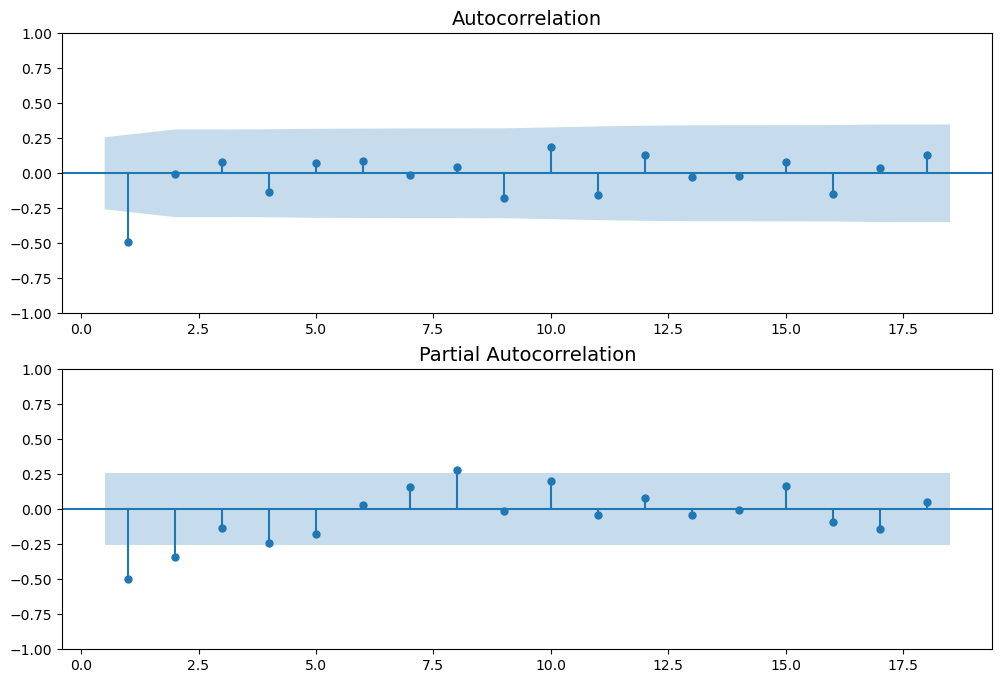

In [16]:
print(check_stationarity(life_diff)) # data became stationary

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)
plt.show()
  ## significance is represented when a lag (vertical line) goes above or below the shaded area

'Non-Stationary	 p-value:0.1607988052771142 	 lags:12
('Non-Stationary', 0.1607988052771142)
'Stationary	 p-value:1.865423431878921e-05 	 lags:11
('Stationary', 1.865423431878921e-05)


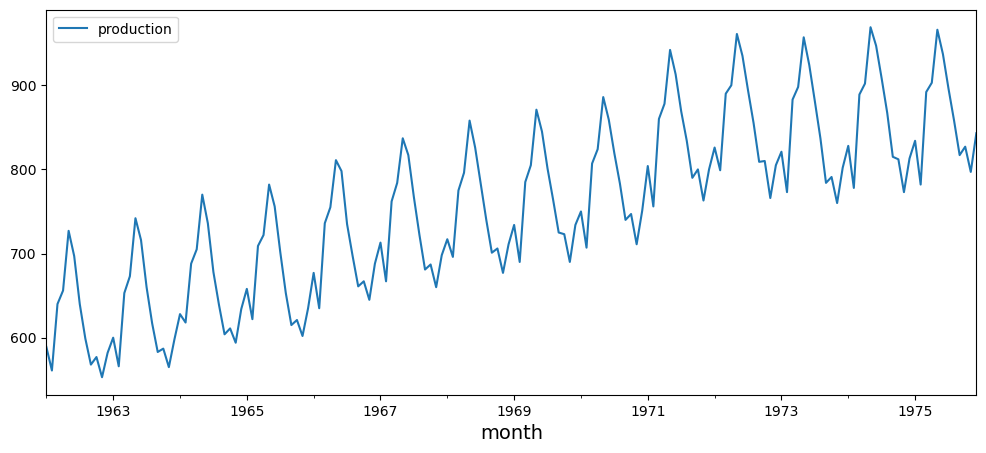

In [17]:
### Lets see ACF and PACF plots for more complex data with 
       # trend and seasonality

## SARIMA model is more suitable in this case. SARIMA model has 2 components: 
       #  a non-seasonla and a Seasonal. 
       # For above example for non-seasonal AR and MA represented by p , q
       # for seasonal along with p, q we have to find SEASONAL AR and MA
       # which is represented by P, Q. SARIMA(p, d, q)(P, D, Q, S).

# to make the timeseries stationary, we must start with seasonal differencing 
     # to remove seasonal effect.


milk.plot()

milk_diff_12 = milk.diff(12).dropna() # seasonal effects observed annually so 12

print(check_stationarity(milk_diff_12))
  # differenced time series still not stationary. so do second order differencing

milk_diff_12_1 = milk.diff(12).diff(1).dropna()
print(check_stationarity(milk_diff_12_1)) # now we got stationary process

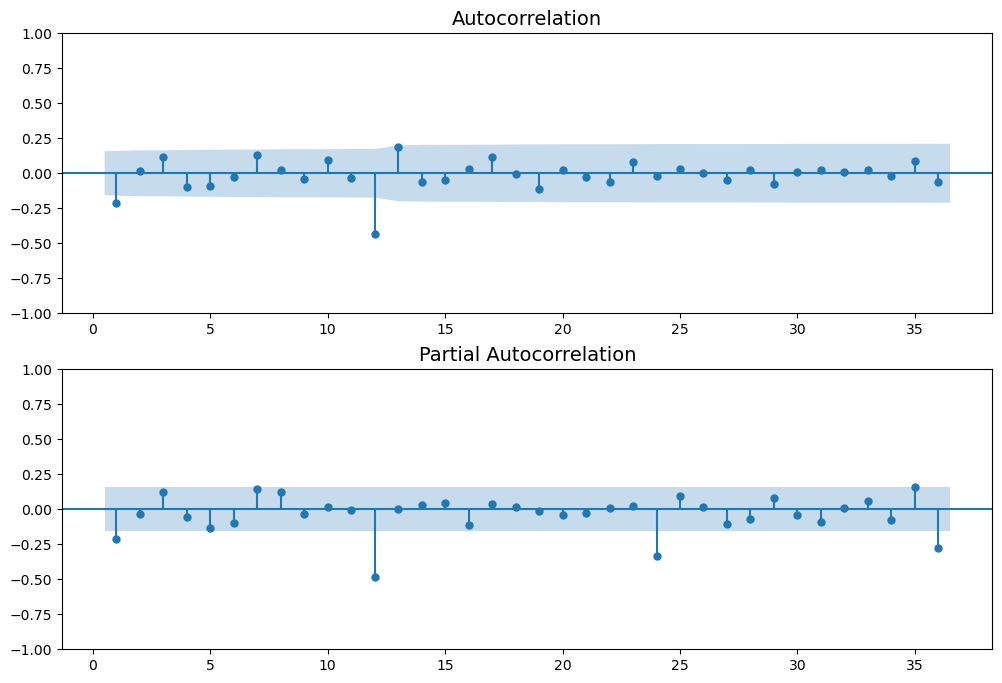

In [18]:
## plot ADF and PADF for the stationary time series
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
# plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()

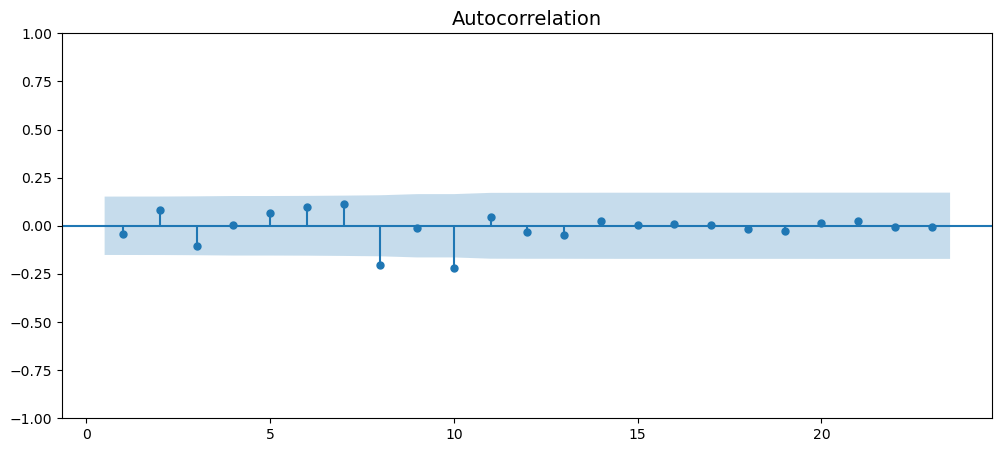

In [19]:
## lets build SARIMA model with order (0, 1, 1)(0, 1, 1, 12)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
#plt.savefig('images/fig_10.4.png', bbox_inches='tight', dpi=300)
plt.show()
     # after model has been built, the acf plot still 
     # shows slightly significant lags indicating the 
     # existance of some auto correlation in the residuals
     # which means model didnot capture all the info.

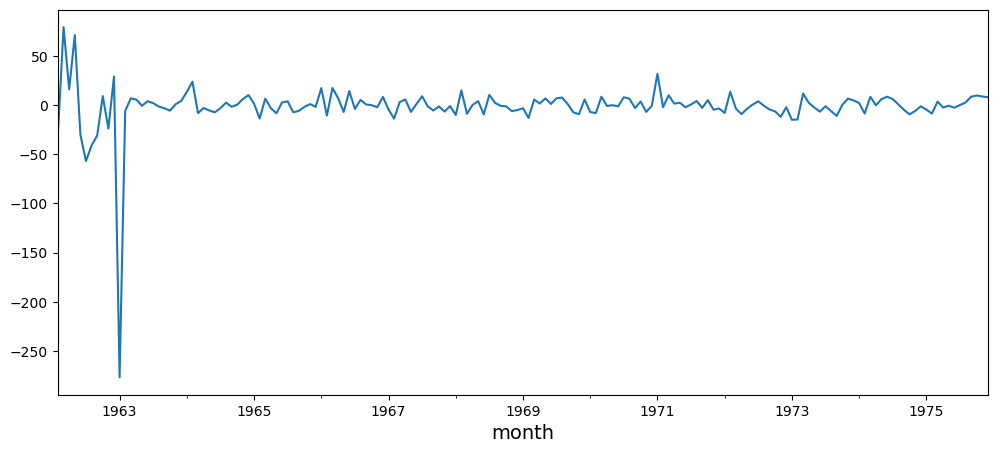

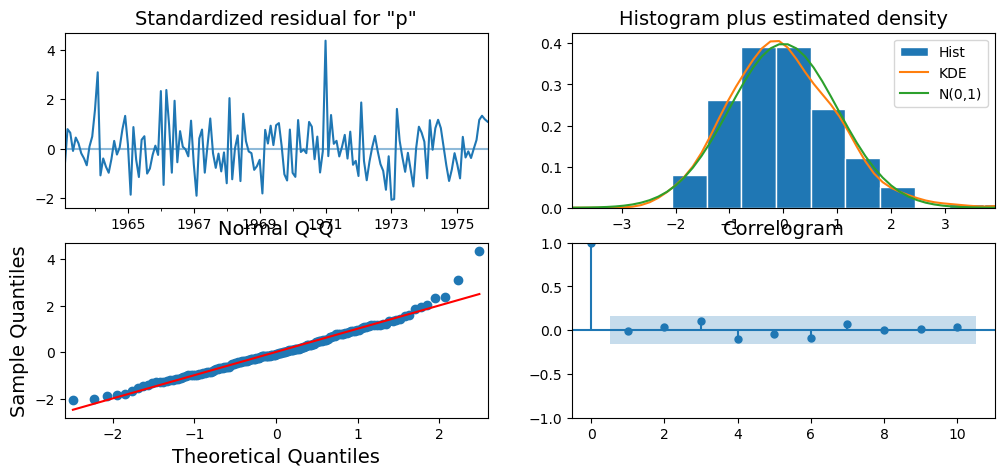

In [20]:
model.resid[1:].plot();

model.plot_diagnostics();

## Forecasting univariate time series data with exponential smoothing

**SimpleExpSmoothing or single exponential smoothing**: Simple exponential smoothing is used when the time series process lacks seasonality and trend. 

**Holt's exponential smoothing or double exponential smoothing**: is used when the time series process contains only trend (but no seasonality). 

**Holt-Winters' exponential smoothing or Triple exponential smoothing**:It is used when the time series process has both seasonality and trend. 

Hyper parameters
* smoothing_level: A float value for the smoothing factor for the level known as alpha (𝛼), where 0 ≤ 𝛼 ≤ 1.
* smoothing_trend: A float value for the smoothing factor for the trend known as beta (𝛽), where 0 ≤ 𝛽 ≤ 1.
* smoothing_seasonal: A float value for the smoothing factor for the seasonal trend known as gamma (𝛾), where 0 ≤ 𝛾 ≤ 1. 
* trend: A single choice from (multiplicative or mul), (additive or add), or None.
* seasonal: A single choice from (multiplicative or mul), (additive or add), or None.
* seasonal_periods: Takes an integer value representing the seasonality period, for example, 12 if the data is monthly or 4 if the information is quarterly.
* damped_trend: A Boolean value that is either True or False. 
* use_boxcox: A Boolean value that is either True or False to determine if a Box-Cox transform should be applied.

Moving average model treat past values equally, while exponential smoothing type models put more emphasis (weight) on more recent observations (i.e older observations decay in weight exponentially). This approach is useful as recent events are likely more important than older events.

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing

trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
print(life_ex_comb)

train = life_train.values.ravel()
y = life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

life_best_model = get_best_model(score, 'AIC')
print(life_best_model)

life_best_model.summary()

[('add', True), ('add', False), ('mul', True), ('mul', False)]
Best model: 1 with lowest AIC score: -137.03060179498183


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    endog   No. Observations:                   50
Model:             ExponentialSmoothing   SSE                              2.749
Optimized:                         True   AIC                           -137.031
Trend:                         Additive   BIC                           -129.383
Seasonal:                          None   AICC                          -135.077
Seasonal Periods:                  None   Date:                 Mon, 14 Nov 2022
Box-Cox:                          False   Time:                         20:13:41
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1621953                alpha                 True
smoothing_trend            0.1621953                 beta                 True
initial_level              68.748480                  l.0                 True
initial_trend              0.2422271                  b.0                 True
------------------------------------------------------------------------------
"""

                  name      param  optimized
smoothing_level  alpha   0.162195       True
smoothing_trend   beta   0.162195       True
initial_level      l.0  68.748480       True
initial_trend      b.0   0.242227       True


<AxesSubplot:xlabel='year'>

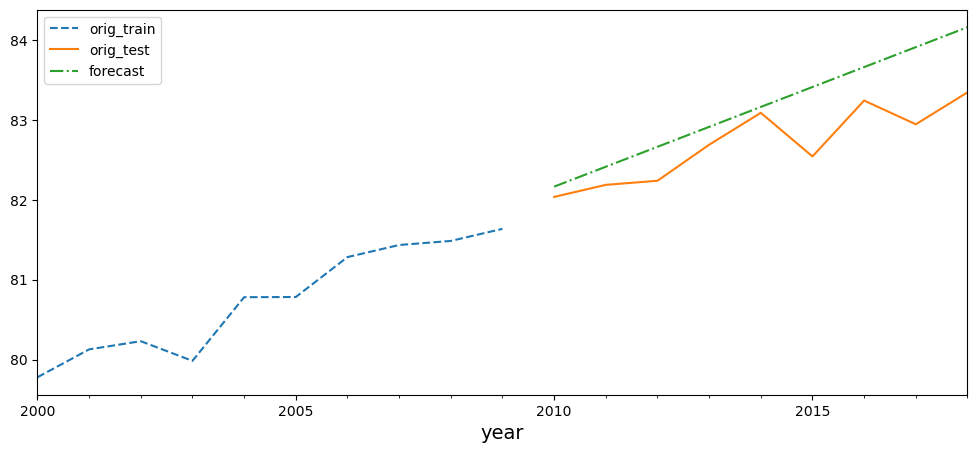

In [22]:
print(life_best_model.params_formatted)

plot_forecast(life_best_model, '2000', life_train, life_test)
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [23]:
### applying Exponential Smoothing on milk dataframe

trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

print(milk_exp_comb)

train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    milk_model_scores[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc': model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

milk_model = get_best_model(milk_model_scores)
milk_model.summary()


[('add', True, 'add', 4), ('add', True, 'add', 6), ('add', True, 'add', 12), ('add', True, 'mul', 4), ('add', True, 'mul', 6), ('add', True, 'mul', 12), ('add', False, 'add', 4), ('add', False, 'add', 6), ('add', False, 'add', 12), ('add', False, 'mul', 4), ('add', False, 'mul', 6), ('add', False, 'mul', 12), ('mul', True, 'add', 4), ('mul', True, 'add', 6), ('mul', True, 'add', 12), ('mul', True, 'mul', 4), ('mul', True, 'mul', 6), ('mul', True, 'mul', 12), ('mul', False, 'add', 4), ('mul', False, 'add', 6), ('mul', False, 'add', 12), ('mul', False, 'mul', 4), ('mul', False, 'mul', 6), ('mul', False, 'mul', 12)]
Best model: 8 with lowest AIC score: 593.7138793829723


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    endog   No. Observations:                  143
Model:             ExponentialSmoothing   SSE                           7265.655
Optimized:                         True   AIC                            593.714
Trend:                         Additive   BIC                            641.119
Seasonal:                      Additive   AICC                           599.230
Seasonal Periods:                    12   Date:                 Mon, 14 Nov 2022
Box-Cox:                          False   Time:                         20:13:43
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6859383                alpha                 True
smoothing_trend                0.000000                 beta                 True
smoothing_seasonal            0.1476582                gamma                 True
initial_level                 607.36532                  l.0                 True
initial_trend                 1.6561445                  b.0                 True
initial_seasons.0            -19.966613                  s.0                 True
initial_seasons.1            -51.572875                  s.1                 True
initial_seasons.2             34.501337                  s.2                 True
initial_seasons.3             48.811378                  s.3                 True
initial_seasons.4             111.95263                  s.4                 True
initial_seasons.5             85.913387                  s.5                 True
initial_seasons.6             31.130403                  s.6                 True
initial_seasons.7            -15.265838                  s.7                 True
initial_seasons.8            -56.182434                  s.8                 True
initial_seasons.9            -53.502477                  s.9                 True
initial_seasons.10           -78.982914                 s.10                 True
initial_seasons.11           -43.520449                 s.11                 True
---------------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='month'>

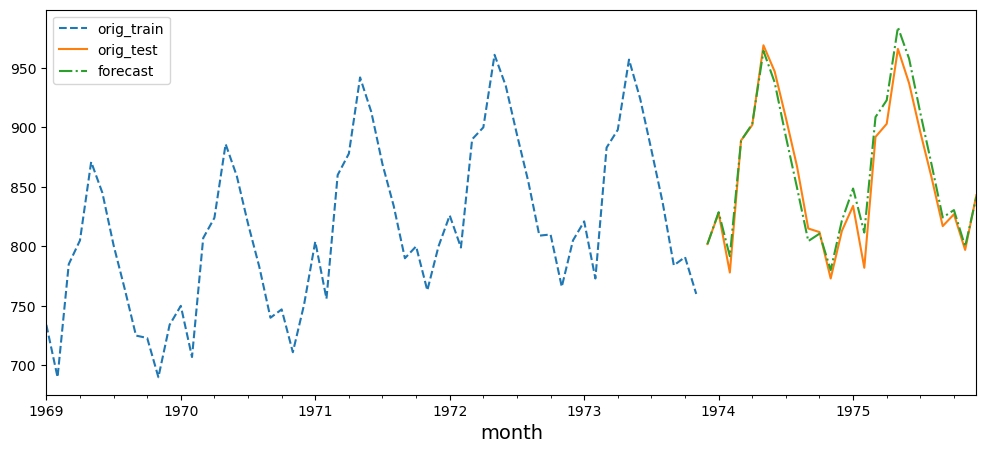

In [24]:
plot_forecast(milk_model, '1969', milk_train, milk_test)

In [25]:
### usind darts package

# from darts.models import ExponentialSmoothing
# from darts import Timeseries

# model = ExponentialSmoothing(seasonal_periods=12)
# ts = Timeseries.from_dataframe(milk.reset_index(), 
#         time_col='month', value_cols='production', freq='MS')

# train, test = split_data(ts, 0.15)
# model.fit(train)
# forecast = model.predict(len(test), num_samples=100)
# train.plot()
# forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# # plt.savefig('images/fig_10.9.png', bbox_inches='tight', dpi=300)
# model.model.summary()


### Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

ARIMA models can handle non-stationary time series data through differencing.
ARIMA models dont assume stationarity but assumes for no seasonality.

so if seasonality exists, use SARIMA model.

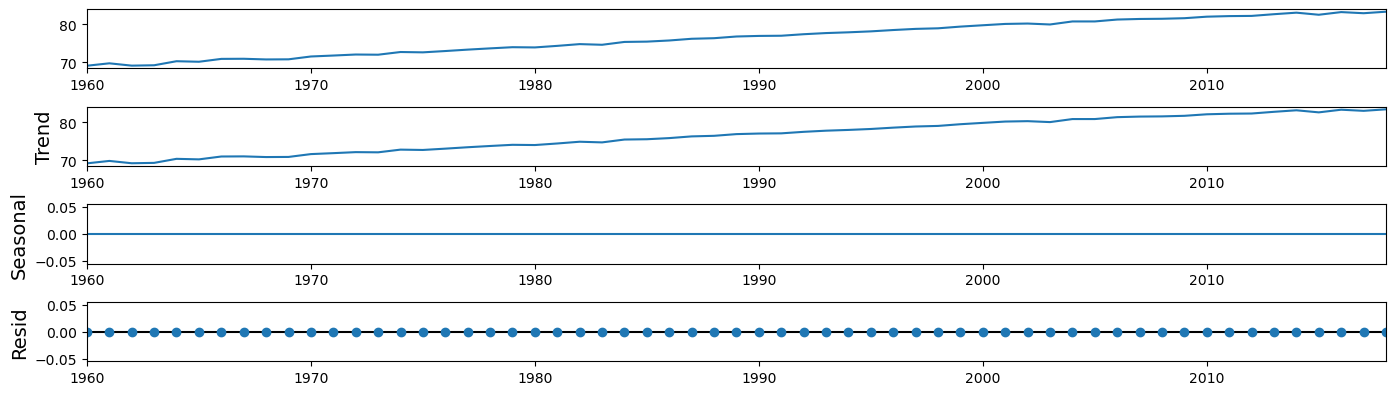

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.tsa.api import seasonal_decompose

plt.rcParams["figure.figsize"] = [14, 4] 


decomposed = seasonal_decompose(life)
decomposed.plot()
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)
plt.show()

'Non-Stationary	 p-value:0.6420882853800051 	 lags:2
('Non-Stationary', 0.6420882853800051)
'Stationary	 p-value:1.556218967600307e-14 	 lags:1
('Stationary', 1.556218967600307e-14)


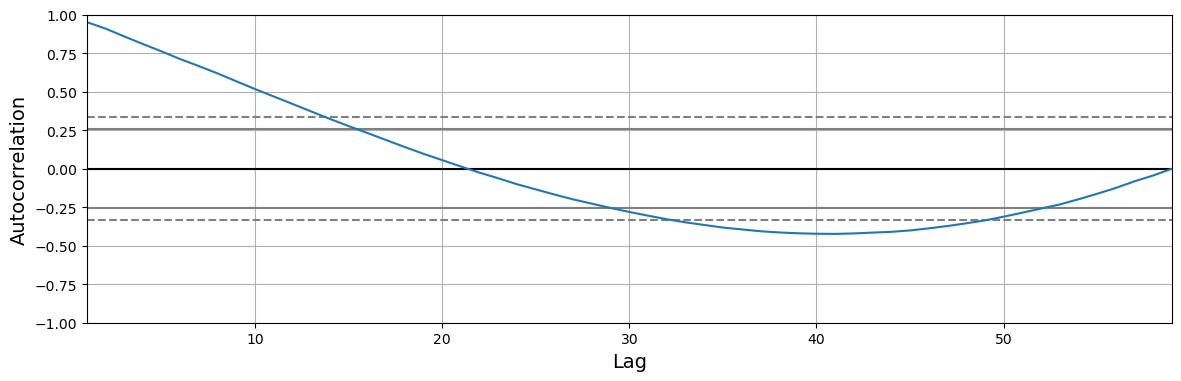

In [27]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(life)
print(check_stationarity(life))

life_df1 = life.diff().dropna()
print(check_stationarity(life_df1))

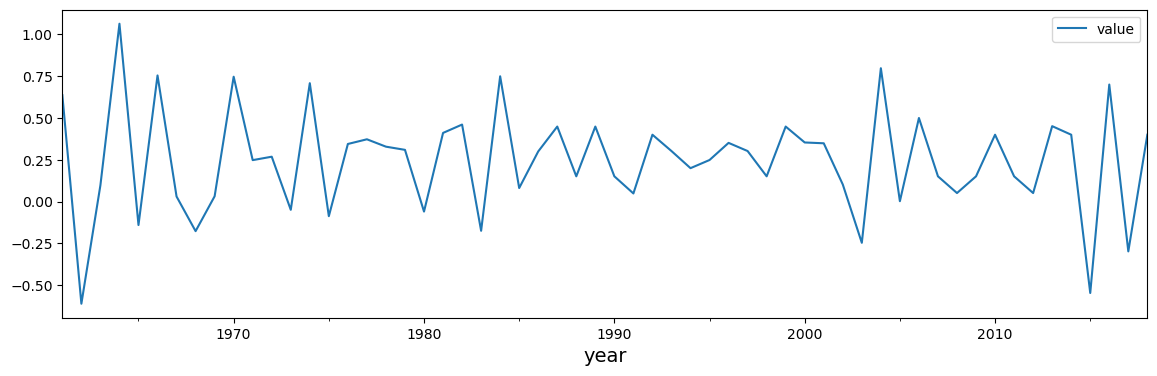

In [28]:
life_df1.plot(); # made data to stationary


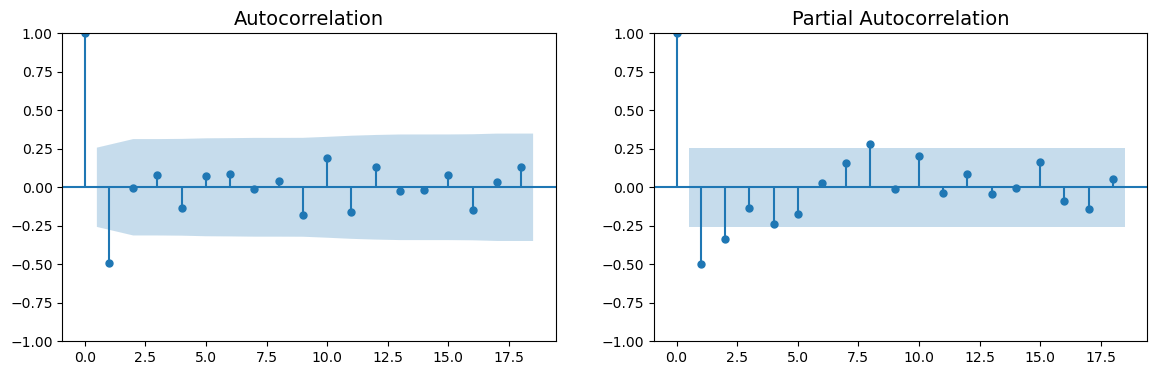

In [29]:
## acf and pacf plos to get p, q values

fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1])
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)
plt.show()

In [30]:
print((acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum())
# there is autocorrelation as we would expect 

model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

     ## AIC and BIC values are meaningful when we are comparing multiple models


24


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Mon, 14 Nov 2022   AIC                             52.321
Time:                        20:13:44   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0


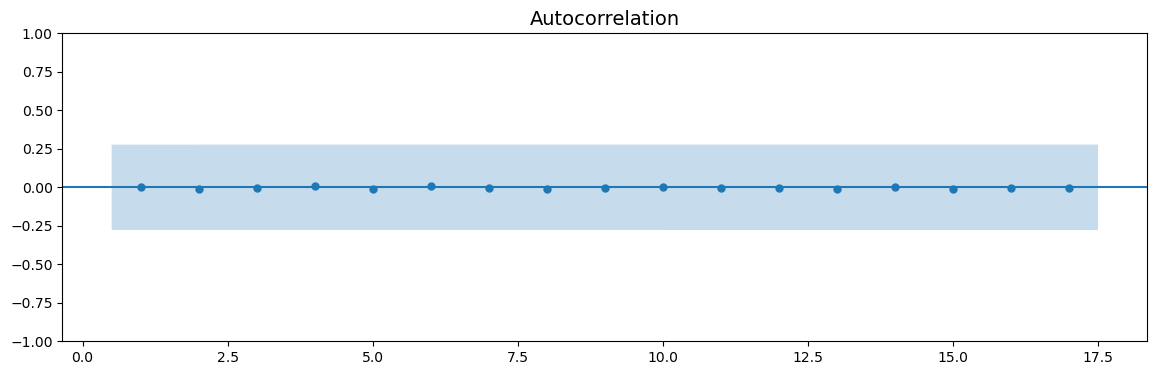

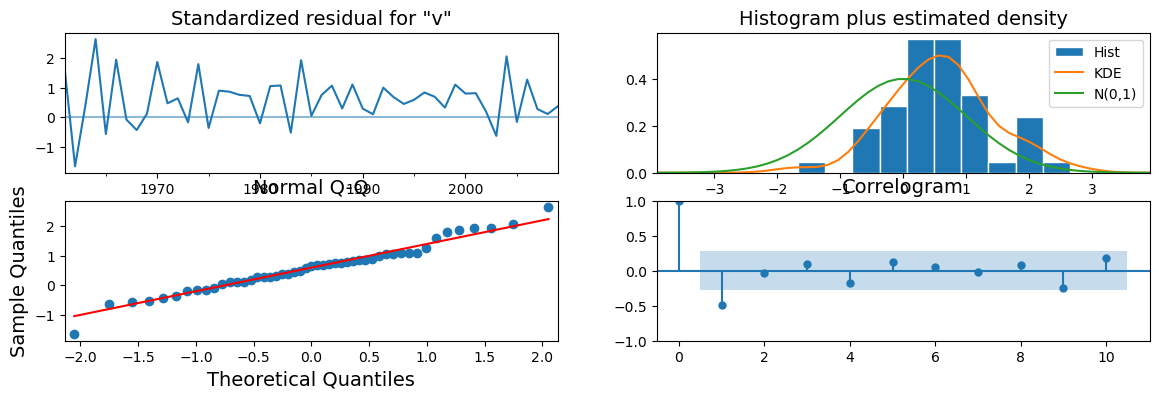

In [31]:
## if model captures all the information, then model's residuals 
         # are random and donot follow any pattern.i.e. no autocorelation
print((acorr_ljungbox(results.resid, 
    lags=25,
    return_df=True) < 0.05)['lb_pvalue'].sum()) # aggreagate of the results for first 25 lags 
                                                  #indicating 0 autocorrelation

plot_acf(results.resid, zero=False);plt.show() # no significant lags present


results.plot_diagnostics();
      # we would expect normally distributed residuals with mean of 0
      
    ## From all above we see its a decent model

<AxesSubplot:xlabel='year'>

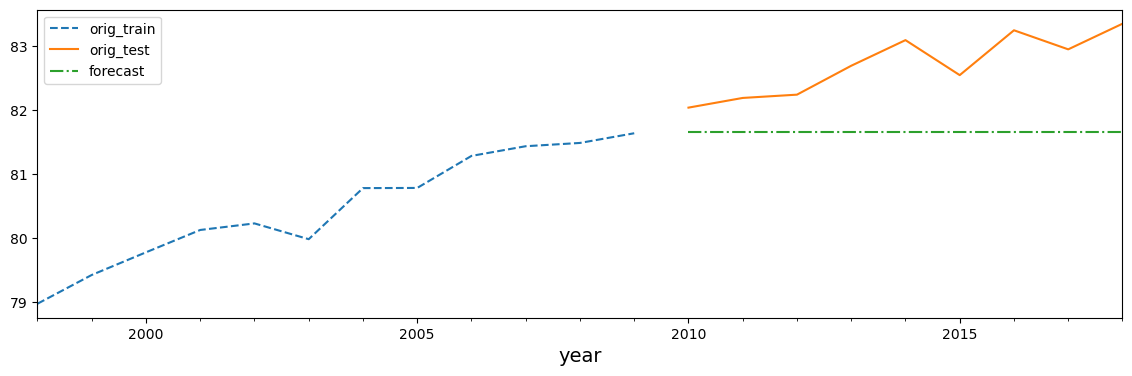

In [32]:
## forcast using arima model

plot_forecast(results, '1998', life_train, life_test)
   ## forcast doesnt seems to follow the trend. exponential smoothing 
   # did much better job than this.

  ## so usually, we have to run multiple ARIMA models and choose best model


Autoregression model or AR(p) is a linear model that uses observations 
from the previous time steps as inputs in to regression equation to predict
next step.

Regression equation:

                   𝑦 = 𝑚 + θ1𝑥1 + θ2𝑥2 + ⋯ + θ𝑛𝑥𝑛 + ϵt
y -> predicted value
m -> intercept
x1, x2, x3 ... xn -> independent variables
𝜃1, 𝜃2,… , 𝜃n  -> coeff foe each independent variables
ϵn -> error term or noise

Auto Regression Equation:

            𝐴R(𝑝) = 𝑦𝑡 = α + θ1𝑦𝑡−1 + θ2𝑦𝑡−2 + ⋯ + θ𝑝𝑦𝑡−𝑝 + ϵt

so in AutoRegression you are using laged values. above model is ARIMA(0,1,1)
so, it is AR(0) indicating no autoregressive model being used.

Unlike AutoRegressive model that uses past values, Moving average uses 
past error terms (from past estimates) to make predictions

            𝑀A(𝑞) = 𝑦𝑡 = β + θ1ϵ𝑡−1 + θ2ϵ𝑡−2 + ⋯ + θ𝑝ϵ𝑡−𝑞 + ϵt

ARMA model is Autoregression moving Average model. both AR and ARMA assumes
a stationary timeseries. if trend component is present in timseries data,
then it becomes non-stationary and we cannot use AR, ARMA models.

ARIMA model improves the ARMA model by adding an integrated factor to make 
timeseries stationary.

One of the reasons ARIMA is popular is because it generalizes to other simpler models, 
as follows:
• ARIMA(1, 0, 0) is a first-order autoregressive or AR(1) model 
• ARIMA(1, 1, 0) is a differenced first-order autoregressive model
• ARIMA(0, 0, 1) is a first-order moving average or MA(1) model 
• ARIMA(1, 0, 1) is an ARMA (1,1) model 
• ARIMA(0, 1, 1) is a simple exponential smoothing model 

In [33]:
## using combinator to to find best p, d, q values

pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

print(get_best_model(score, 'AIC'))

best_m = get_best_model(score, 'AIC')

print(score[8]) # printing best model scores

print(score[4]['model'].model_orders)

## observing all scores in a dataframe with AIC score
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()


Best model: 8 with lowest AIC score: 7.699110686705648
Best model: 8 with lowest AIC score: 7.699110686705648
{'order': (0, 2, 2), 'AIC': 7.699110686705648, 'BIC': 13.312713719429322, 'AICc': 8.244565232160195, 'RMSPE': 0.0559525018492127, 'RMSE': 0.4635498125684355, 'MAPE': 0.004493857065979613, 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000026F0B1FE970>}
{'trend': 0, 'exog': 0, 'ar': 0, 'ma': 1, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 0, 'reduced_ma': 1, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}


index      order         AIC         BIC        AICc     RMSPE      RMSE  \
0       8  (0, 2, 2)    7.699111   13.312714    8.244565  0.055953   0.46355   
1      14  (1, 1, 2)    9.533199    17.10048    10.44229  0.054758  0.453637   
2      17  (1, 2, 2)    9.678472   17.163276   10.608704  0.055723  0.461647   
3      23  (2, 1, 2)   11.509602   20.968704   12.904951  0.054477  0.451304   
4      26  (2, 2, 2)   13.830106   23.186111   15.258677  0.074285  0.615786   
5      25  (2, 2, 1)   19.673416    27.15822   20.603649  0.054422  0.451287   
6      16  (1, 2, 1)   23.192046   28.805649   23.737501  0.048502  0.402158   
7      22  (2, 1, 1)   25.291029    32.85831    26.20012  0.046821  0.388198   
8       7  (0, 2, 1)   31.315044   35.057446   31.581711  0.047363  0.392699   
9      13  (1, 1, 1)   33.426614   39.102074   33.959947  0.043396  0.359744   
10     24  (2, 2, 0)   38.494179   44.107782   39.039633  0.068813    0.5712   
11     21  (2, 1, 0)   46.663141   52.338602   47.196475  0.124676  1.035326   
12      5  (0, 1, 2)   47.416209    53.09167   47.949543  0.137404  1.140837   
13      3  (0, 1, 0)   50.840699   52.732519   50.925805  0.139629  1.159287   
14     12  (1, 1, 0)    51.96437    55.74801   52.225239  0.137018  1.137674   
15      4  (0, 1, 1)   52.321115   56.104755   52.581984  0.138272  1.148057   
16     15  (1, 2, 0)   53.276398     57.0188   53.543065  0.069694  0.578489   
17     11  (1, 0, 2)   57.760866   67.320981   59.124502  0.149686  1.242839   
18      9  (1, 0, 0)   61.262602   66.998671   61.784341  0.148575  1.233564   
19     18  (2, 0, 0)   62.380172   70.028264   63.269061  0.148488  1.232922   
20     10  (1, 0, 1)   62.740976   70.389068   63.629864  0.148492  1.232918   
21     19  (2, 0, 1)   65.262585     74.8227   66.626222  0.148483  1.232805   
22     20  (2, 0, 2)   66.446597   77.918735   68.400085  0.148523  1.233191   
23      6  (0, 2, 0)   75.831954   77.703155    75.91891  0.045215  0.375163   
24      2  (0, 0, 2)   179.00982  186.657912  179.898709  0.833926   6.90863   
25      1  (0, 0, 1)  223.397152  229.133221  223.918892  0.857813  7.102549   
26      0  (0, 0, 0)  280.675284   284.49933  280.930604  0.883134  7.308425   

        MAPE                                              model  
0   0.004494  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
1   0.004395  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
2   0.004469  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
3   0.004365  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
4   0.006201  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
5   0.003984  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
6   0.003586  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
7     0.0035  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
8   0.003599  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
9    0.00338  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
10  0.006244  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
11  0.011395  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
12  0.012661  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
13  0.012861  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
14   0.01258  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
15  0.012713  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
16  0.006349  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
17  0.013762  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
18  0.013675  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
19  0.013618  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
20  0.013641  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
21  0.013667  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
22    0.0136  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
23  0.003742  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
24  0.080613  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
25  0.084819  <statsmodels.tsa.arima.model.ARIM

In [34]:
## comparing score for all models based on BIC
pd.DataFrame(score).T.sort_values(by='BIC').reset_index()

index      order         AIC         BIC        AICc     RMSPE      RMSE  \
0       8  (0, 2, 2)    7.699111   13.312714    8.244565  0.055953   0.46355   
1      14  (1, 1, 2)    9.533199    17.10048    10.44229  0.054758  0.453637   
2      17  (1, 2, 2)    9.678472   17.163276   10.608704  0.055723  0.461647   
3      23  (2, 1, 2)   11.509602   20.968704   12.904951  0.054477  0.451304   
4      26  (2, 2, 2)   13.830106   23.186111   15.258677  0.074285  0.615786   
5      25  (2, 2, 1)   19.673416    27.15822   20.603649  0.054422  0.451287   
6      16  (1, 2, 1)   23.192046   28.805649   23.737501  0.048502  0.402158   
7      22  (2, 1, 1)   25.291029    32.85831    26.20012  0.046821  0.388198   
8       7  (0, 2, 1)   31.315044   35.057446   31.581711  0.047363  0.392699   
9      13  (1, 1, 1)   33.426614   39.102074   33.959947  0.043396  0.359744   
10     24  (2, 2, 0)   38.494179   44.107782   39.039633  0.068813    0.5712   
11     21  (2, 1, 0)   46.663141   52.338602   47.196475  0.124676  1.035326   
12      3  (0, 1, 0)   50.840699   52.732519   50.925805  0.139629  1.159287   
13      5  (0, 1, 2)   47.416209    53.09167   47.949543  0.137404  1.140837   
14     12  (1, 1, 0)    51.96437    55.74801   52.225239  0.137018  1.137674   
15      4  (0, 1, 1)   52.321115   56.104755   52.581984  0.138272  1.148057   
16     15  (1, 2, 0)   53.276398     57.0188   53.543065  0.069694  0.578489   
17      9  (1, 0, 0)   61.262602   66.998671   61.784341  0.148575  1.233564   
18     11  (1, 0, 2)   57.760866   67.320981   59.124502  0.149686  1.242839   
19     18  (2, 0, 0)   62.380172   70.028264   63.269061  0.148488  1.232922   
20     10  (1, 0, 1)   62.740976   70.389068   63.629864  0.148492  1.232918   
21     19  (2, 0, 1)   65.262585     74.8227   66.626222  0.148483  1.232805   
22      6  (0, 2, 0)   75.831954   77.703155    75.91891  0.045215  0.375163   
23     20  (2, 0, 2)   66.446597   77.918735   68.400085  0.148523  1.233191   
24      2  (0, 0, 2)   179.00982  186.657912  179.898709  0.833926   6.90863   
25      1  (0, 0, 1)  223.397152  229.133221  223.918892  0.857813  7.102549   
26      0  (0, 0, 0)  280.675284   284.49933  280.930604  0.883134  7.308425   

        MAPE                                              model  
0   0.004494  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
1   0.004395  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
2   0.004469  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
3   0.004365  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
4   0.006201  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
5   0.003984  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
6   0.003586  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
7     0.0035  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
8   0.003599  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
9    0.00338  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
10  0.006244  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
11  0.011395  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
12  0.012861  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
13  0.012661  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
14   0.01258  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
15  0.012713  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
16  0.006349  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
17  0.013675  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
18  0.013762  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
19  0.013618  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
20  0.013641  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
21  0.013667  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
22  0.003742  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
23    0.0136  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
24  0.080613  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
25  0.084819  <statsmodels.tsa.arima.model.ARIM

<AxesSubplot:xlabel='year'>

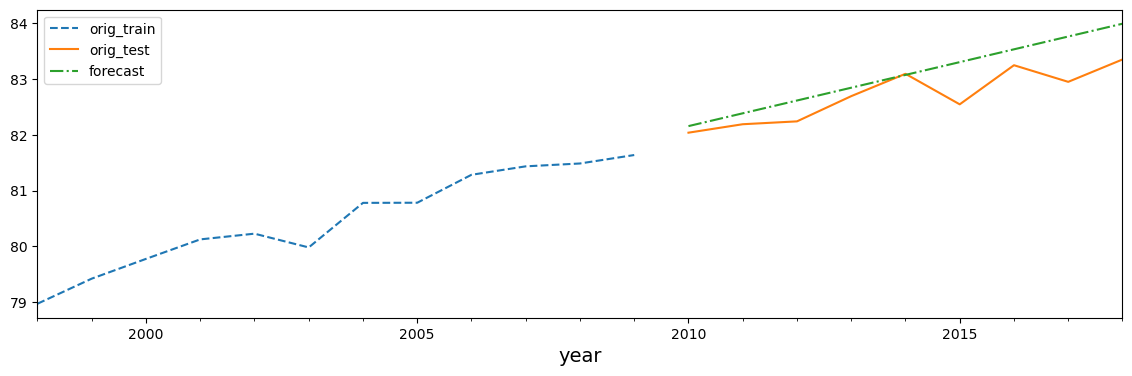

In [35]:
## results are better than (0,1,1) model
plot_forecast(best_m, '1998', life_train, life_test)

### Forecasting Univariate Time Series Data with Seasonal ARIMA

SARIMA -> Seasonal Autoregressive Integrated moving Average.

SARIMA(p, d, q)(P, D, Q, s).

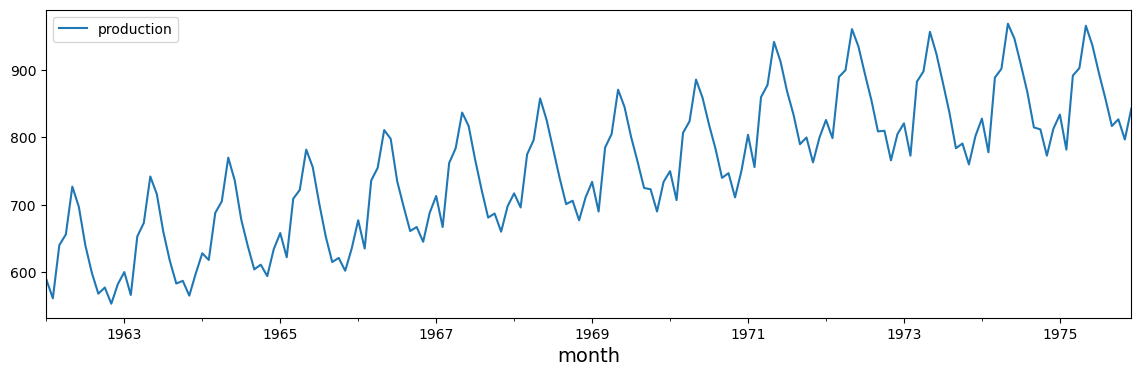

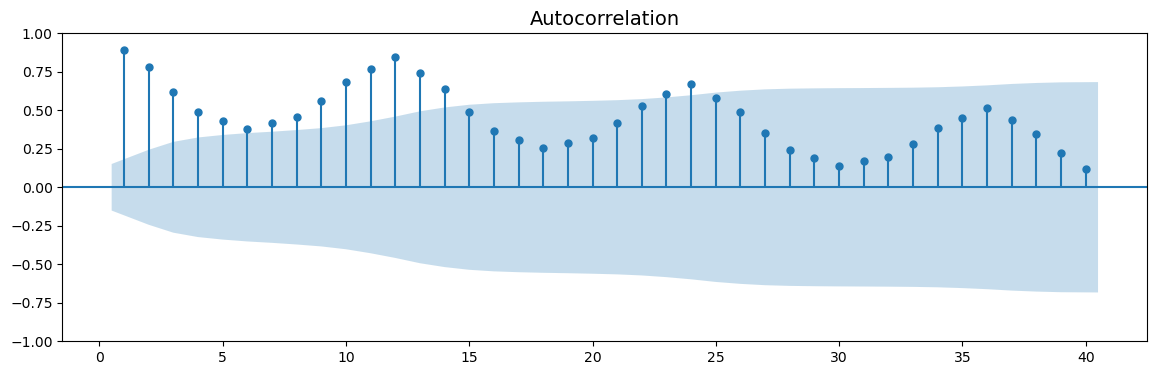

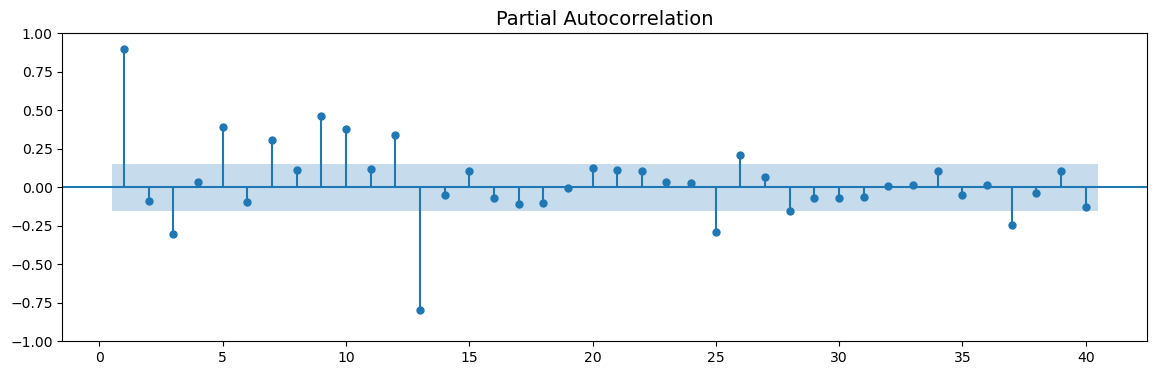

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4] 
milk.plot()

plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

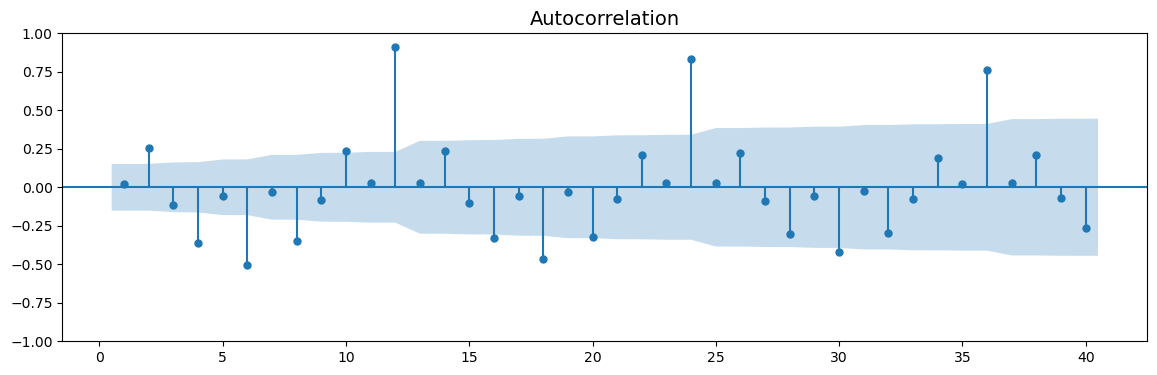

In [37]:
## acf plots after first-order differencing will show similar lag details more clear

plot_acf(milk.diff(1).dropna(), lags=40, zero=False); plt.show()

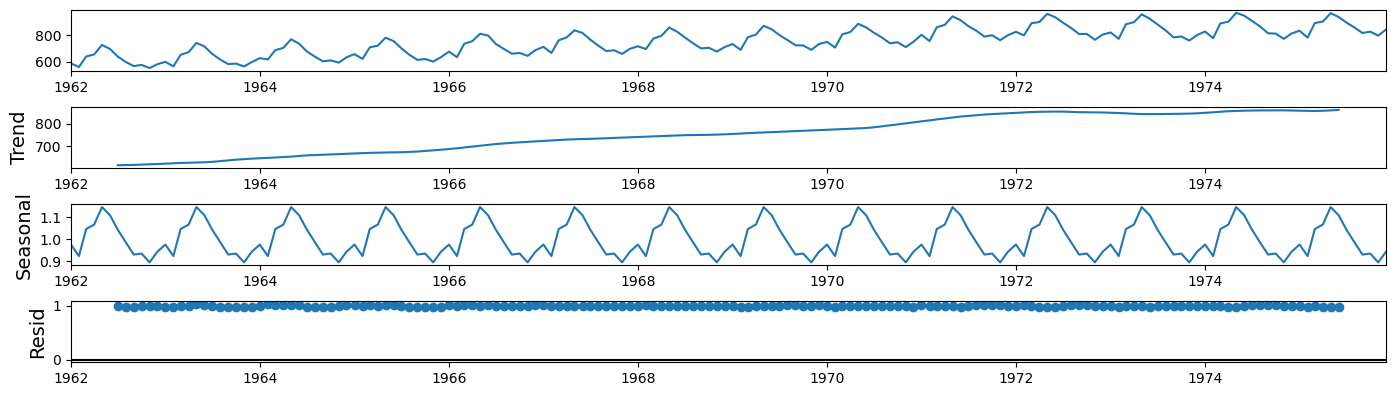

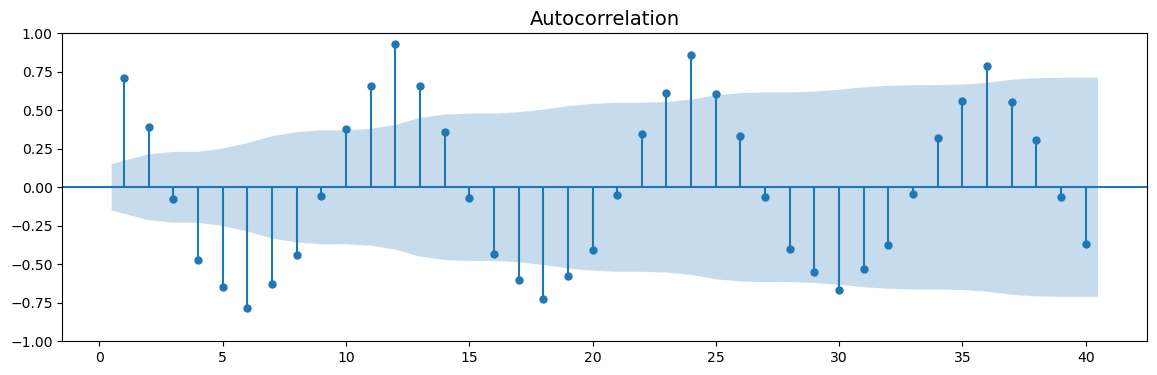

In [38]:
## extract the seasonla component and use that for ACF plots
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); plt.show();

milk_s = decomposed.seasonal

plot_acf(milk_s, zero=False, lags=40);plt.show()

'Non-Stationary	 p-value:0.6274267086030308 	 lags:13
'Non-Stationary	 p-value:0.1607988052771142 	 lags:12
'Stationary	 p-value:1.865423431878921e-05 	 lags:11


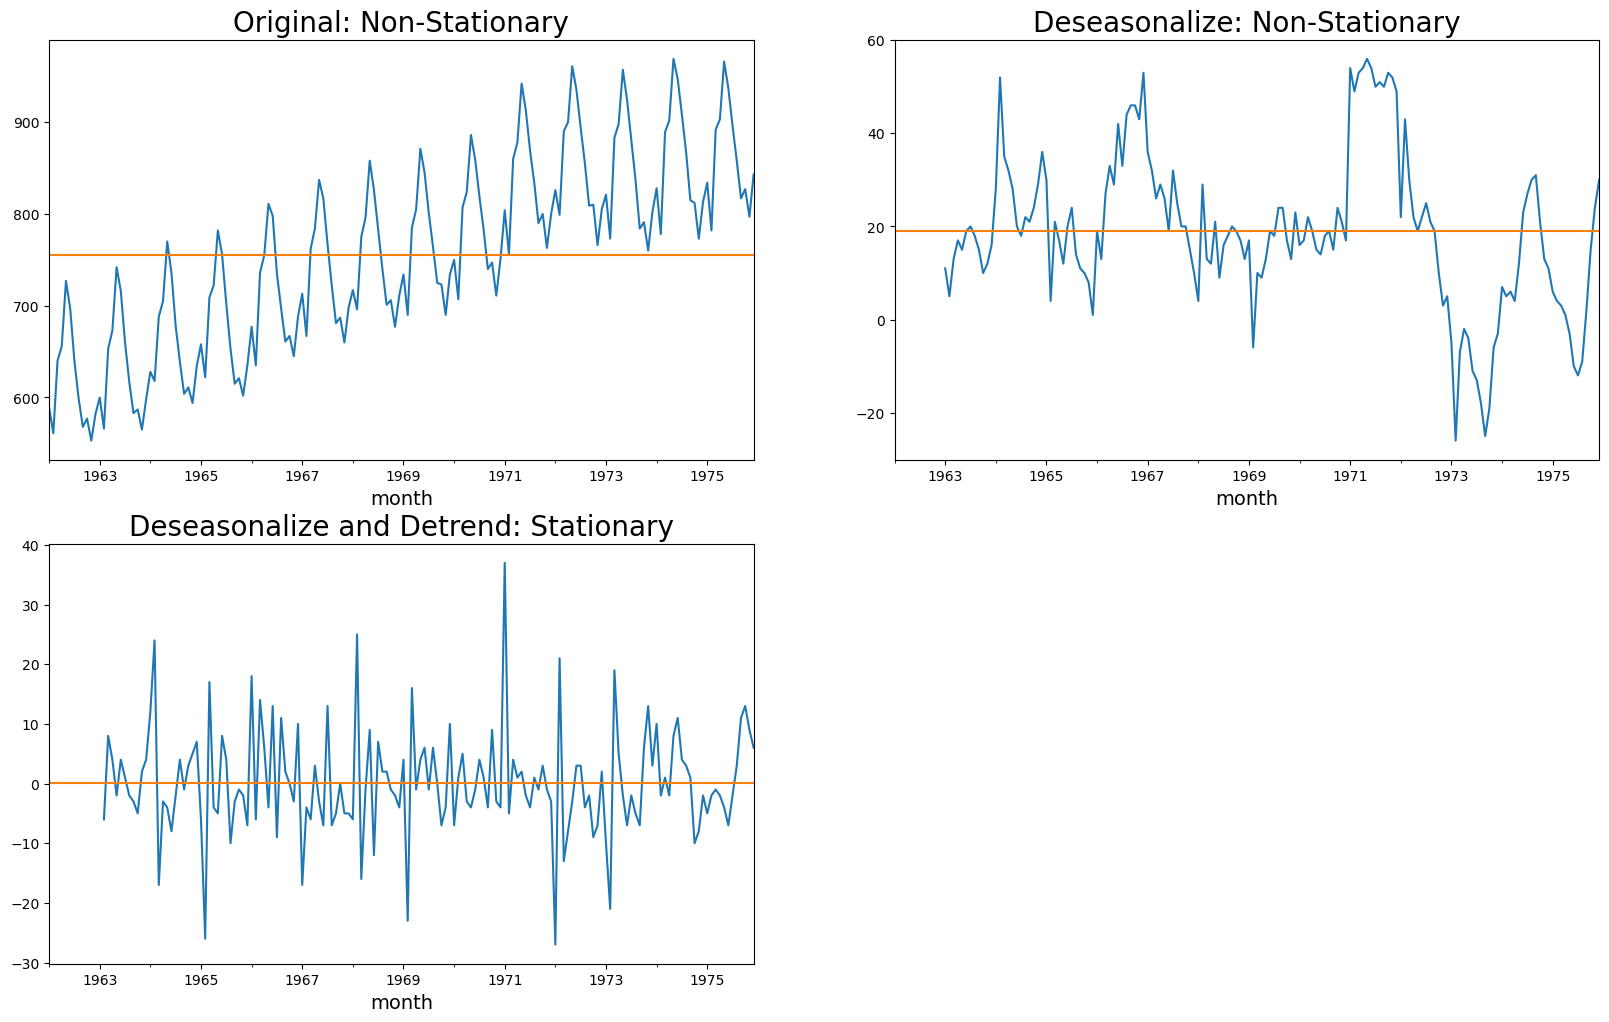

In [39]:
## d and D values can be confirmed by checking the stationarty function after differencing.

milk_dif_12 = milk.diff(12).dropna() # de_seasnlized but still not stationary
milk_dif_12_1 = milk.diff(12).diff(1).dropna() # made data as stationary

sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

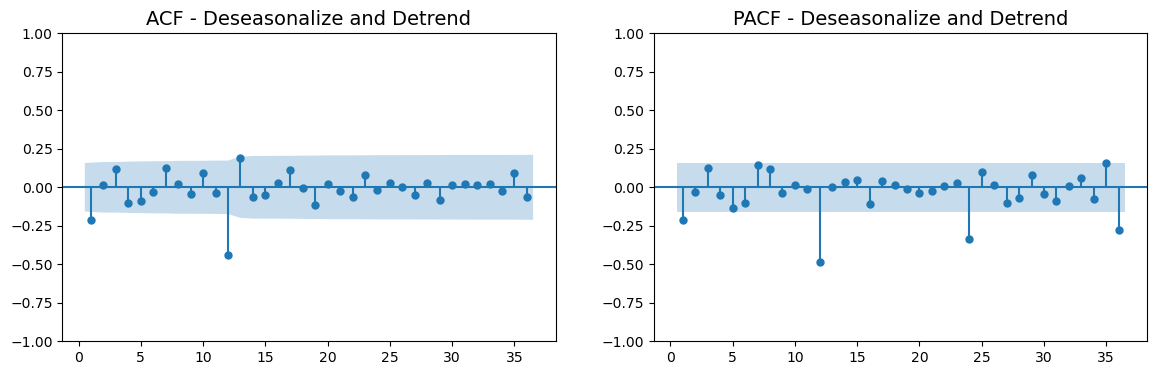

In [40]:
## No estimate AR and MA for non-seaswonal and Seasonal compomenets by using 
              # ACF and PACF plots on stationary data

fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

    ## in ACF plot, there is a significant spike at lag 1, which represents the 
        # non-seasonal order for the MA process. The spike at lag 12 represents 
        # the seasonal order for the MA process. it  indicates of a 
        # moving average model – more specifically, an order of q=1 and Q=1. 
    ## The PACF plot confirms this as well; an exponential decay at lags 
    # 12, 24, and 36 indicates an MA model.


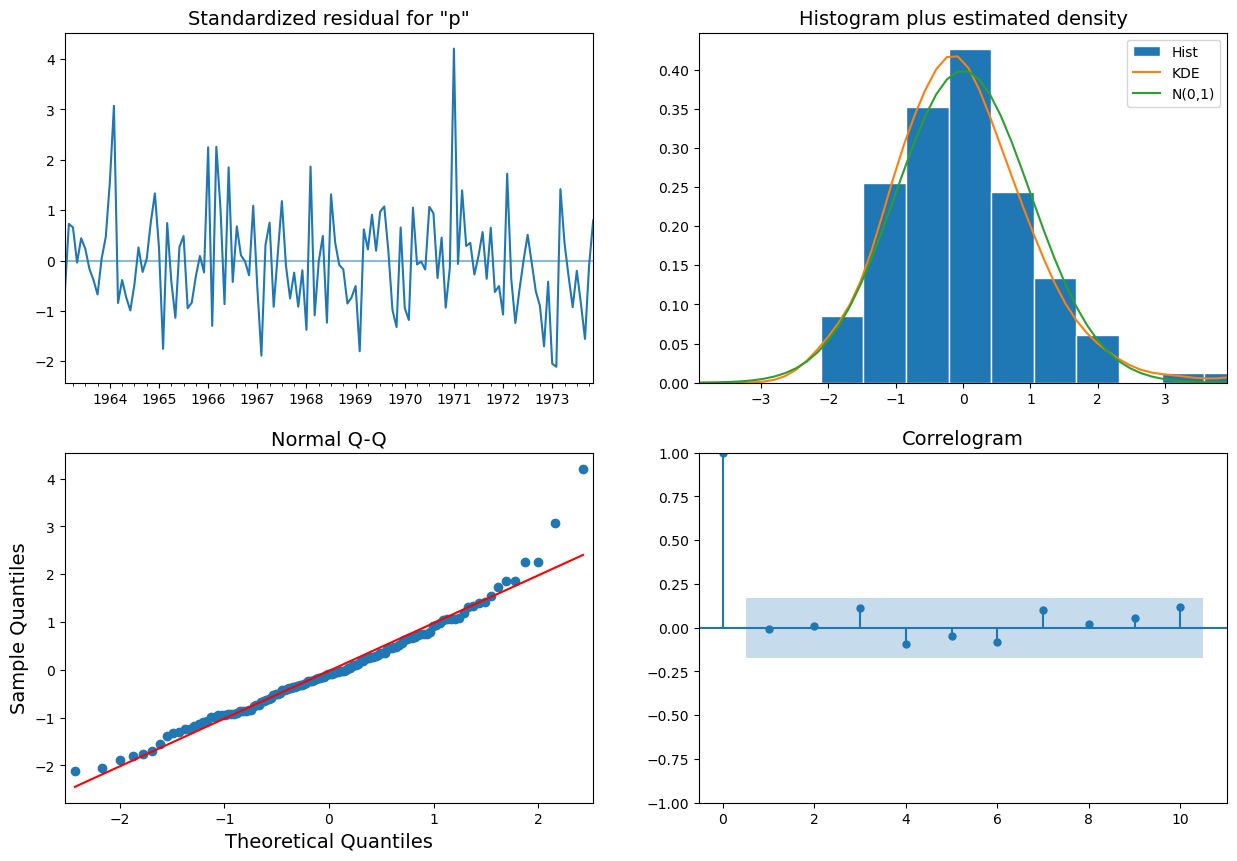

In [41]:
## lets build SARIMA(0, 1, 1)(0, 1, 1, 12)

sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

model.plot_diagnostics(figsize=(15,10))
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)
plt.show()

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Mon, 14 Nov 2022   AIC                            903.335
Time:                                    20:13:48   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

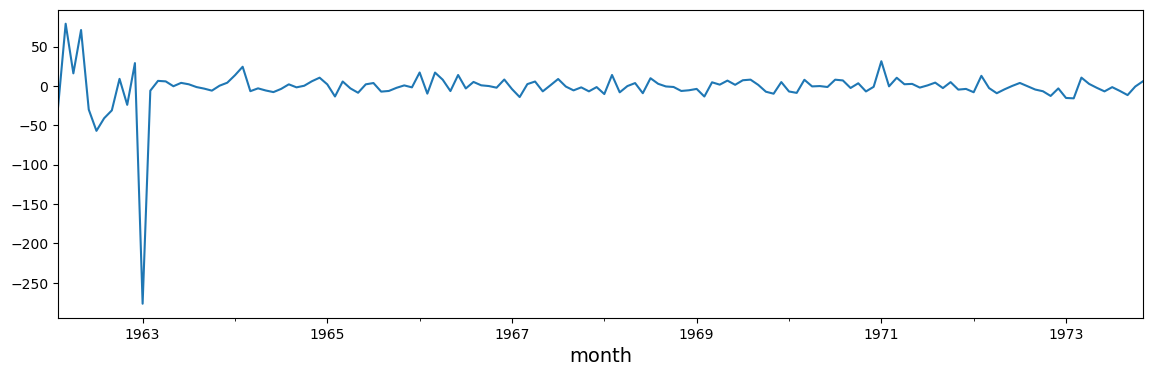

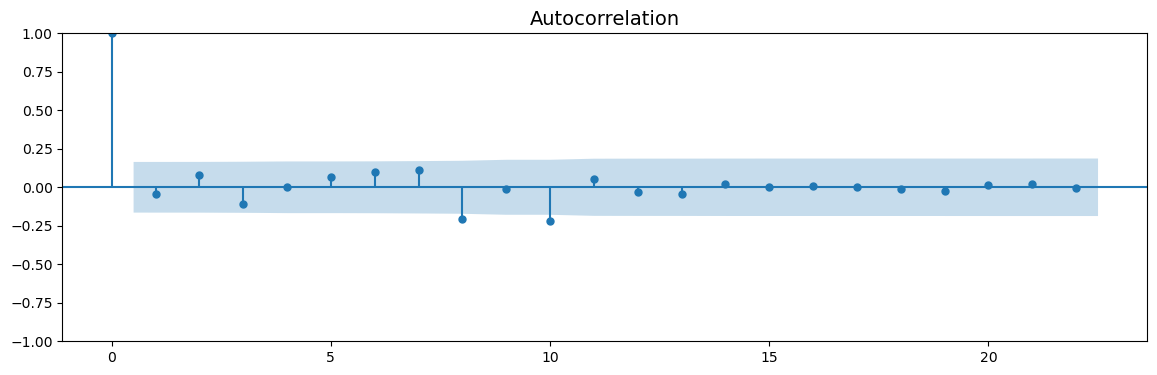

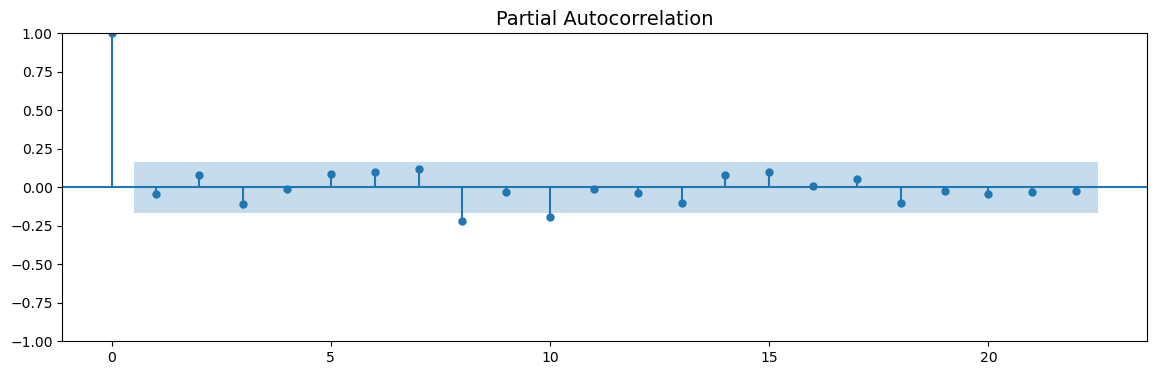

In [43]:
model.resid[1:].plot();

plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show();

<AxesSubplot:xlabel='month'>

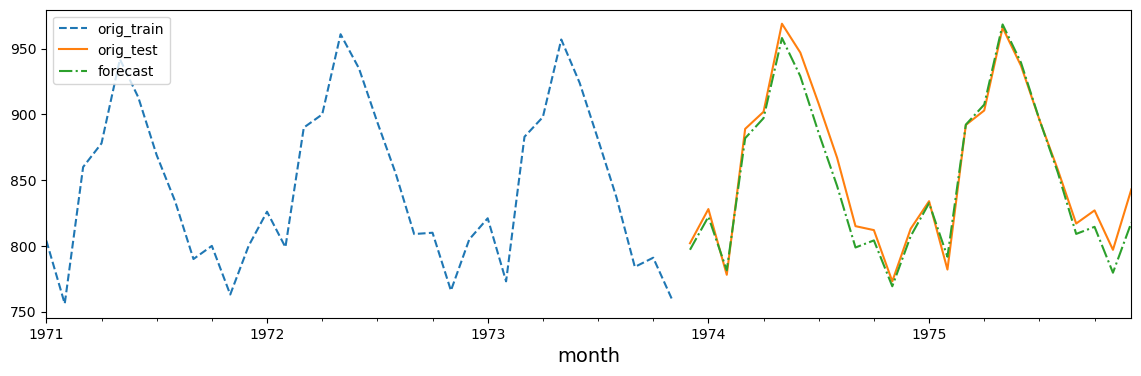

In [44]:
plot_forecast(model, '1971', milk_train, milk_test)
# plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)

     ## this SARIMA model is good and you can iterate over p q P and Q
       # by evaluating metics like AIC, BIC etc



In [45]:
## Iterating models to get best model.

# %%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)


In [46]:
best_model = get_best_model(score, 'AIC')

print(best_model)

results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index()
results.head(20)

Best model: 211 with lowest AIC score: 795.421765228765


index non-seasonal order seasonal order         AIC        AICc  \
0     211          (2, 2, 2)      (0, 1, 1)  795.421765  796.206812   
1      67          (0, 2, 2)      (0, 1, 1)   795.51592  795.882892   
2      43          (0, 1, 2)      (0, 1, 1)  796.763902  797.127539   
3     187          (2, 1, 2)      (0, 1, 1)  796.876071  797.653849   
4     139          (1, 2, 2)      (0, 1, 1)  797.117088  797.672643   
5     191          (2, 1, 2)      (1, 1, 1)  797.162106  798.208835   
6     215          (2, 2, 2)      (1, 1, 1)   797.41933  798.475934   
7     115          (1, 1, 2)      (0, 1, 1)   798.57341  799.123869   
8      47          (0, 1, 2)      (1, 1, 1)  798.638183  799.188641   
9      71          (0, 2, 2)      (1, 1, 1)   798.88124  799.436795   
10    143          (1, 2, 2)      (1, 1, 1)  799.577621  800.362668   
11    119          (1, 1, 2)      (1, 1, 1)  800.347735  801.125512   
12     35          (0, 1, 1)      (0, 1, 1)  802.462674  802.676959   
13    179          (2, 1, 1)      (0, 1, 1)  802.681394  803.226849   
14    131          (1, 2, 1)      (0, 1, 1)  802.770371  803.134007   
15    203          (2, 2, 1)      (0, 1, 1)  803.350097  803.900556   
16     91          (1, 0, 2)      (0, 1, 1)  804.052263  804.597717   
17    107          (1, 1, 1)      (0, 1, 1)  804.143328  804.503688   
18     39          (0, 1, 1)      (1, 1, 1)  804.365835  804.726195   
19    183          (2, 1, 1)      (1, 1, 1)  804.598862  805.369504   

           BIC     RMSPE       RMSE      MAPE  \
0   811.838956   0.17819  15.135857  0.014454   
1   806.460713  0.328243  27.797437  0.028315   
2   807.743631  0.134089  11.487077  0.010387   
3   813.345664   0.12826  10.998611  0.010075   
4    810.79808  0.289728  24.535472   0.02477   
5   816.376631  0.111002   9.550049   0.00903   
6   816.572719  0.179404  15.237416   0.01457   
7   812.298071    0.1356  11.611922  0.010527   
8   812.362843  0.133006  11.396137  0.010312   
9   812.562232  0.427698  36.195514   0.03686   
10  815.994812  0.323599  27.397926  0.027838   
11  816.817327  0.134448  11.515589   0.01043   
12  810.723444   0.13409  11.489677   0.01037   
13  816.449345  0.134386  11.504828  0.010425   
14    813.7501  0.205807  17.449659  0.016939   
15  817.074758  0.315531  26.724338  0.027202   
16  817.820214  0.169371  14.411787   0.01362   
17  815.157689  0.134762  11.543967  0.010431   
18  815.380196  0.132947  11.393404  0.010278   
19  821.120403  0.133267  11.417694  0.010334   

                                                model  
0   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
1   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
2   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
3   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
4   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
5   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
6   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
7   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
8   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
9   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
10  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
11  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
12  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
13  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
14  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
15  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
16  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
17  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
18  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
19  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...

In [47]:
results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()
results.head(20)

index non-seasonal order seasonal order         AIC        AICc  \
0      67          (0, 2, 2)      (0, 1, 1)   795.51592  795.882892   
1      43          (0, 1, 2)      (0, 1, 1)  796.763902  797.127539   
2      35          (0, 1, 1)      (0, 1, 1)  802.462674  802.676959   
3     139          (1, 2, 2)      (0, 1, 1)  797.117088  797.672643   
4     211          (2, 2, 2)      (0, 1, 1)  795.421765  796.206812   
5     115          (1, 1, 2)      (0, 1, 1)   798.57341  799.123869   
6      47          (0, 1, 2)      (1, 1, 1)  798.638183  799.188641   
7      71          (0, 2, 2)      (1, 1, 1)   798.88124  799.436795   
8     187          (2, 1, 2)      (0, 1, 1)  796.876071  797.653849   
9     131          (1, 2, 1)      (0, 1, 1)  802.770371  803.134007   
10    107          (1, 1, 1)      (0, 1, 1)  804.143328  804.503688   
11     39          (0, 1, 1)      (1, 1, 1)  804.365835  804.726195   
12    143          (1, 2, 2)      (1, 1, 1)  799.577621  800.362668   
13    191          (2, 1, 2)      (1, 1, 1)  797.162106  798.208835   
14    179          (2, 1, 1)      (0, 1, 1)  802.681394  803.226849   
15    215          (2, 2, 2)      (1, 1, 1)   797.41933  798.475934   
16    119          (1, 1, 2)      (1, 1, 1)  800.347735  801.125512   
17    203          (2, 2, 1)      (0, 1, 1)  803.350097  803.900556   
18     91          (1, 0, 2)      (0, 1, 1)  804.052263  804.597717   
19     99          (1, 1, 0)      (0, 1, 1)  809.560357  809.772746   

           BIC     RMSPE       RMSE      MAPE  \
0   806.460713  0.328243  27.797437  0.028315   
1   807.743631  0.134089  11.487077  0.010387   
2   810.723444   0.13409  11.489677   0.01037   
3    810.79808  0.289728  24.535472   0.02477   
4   811.838956   0.17819  15.135857  0.014454   
5   812.298071    0.1356  11.611922  0.010527   
6   812.362843  0.133006  11.396137  0.010312   
7   812.562232  0.427698  36.195514   0.03686   
8   813.345664   0.12826  10.998611  0.010075   
9     813.7501  0.205807  17.449659  0.016939   
10  815.157689  0.134762  11.543967  0.010431   
11  815.380196  0.132947  11.393404  0.010278   
12  815.994812  0.323599  27.397926  0.027838   
13  816.376631  0.111002   9.550049   0.00903   
14  816.449345  0.134386  11.504828  0.010425   
15  816.572719  0.179404  15.237416   0.01457   
16  816.817327  0.134448  11.515589   0.01043   
17  817.074758  0.315531  26.724338  0.027202   
18  817.820214  0.169371  14.411787   0.01362   
19  817.846878  0.132352   11.33926  0.010229   

                                                model  
0   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
1   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
2   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
3   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
4   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
5   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
6   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
7   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
8   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
9   <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
10  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
11  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
12  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
13  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
14  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
15  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
16  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
17  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
18  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
19  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...

<AxesSubplot:xlabel='month'>

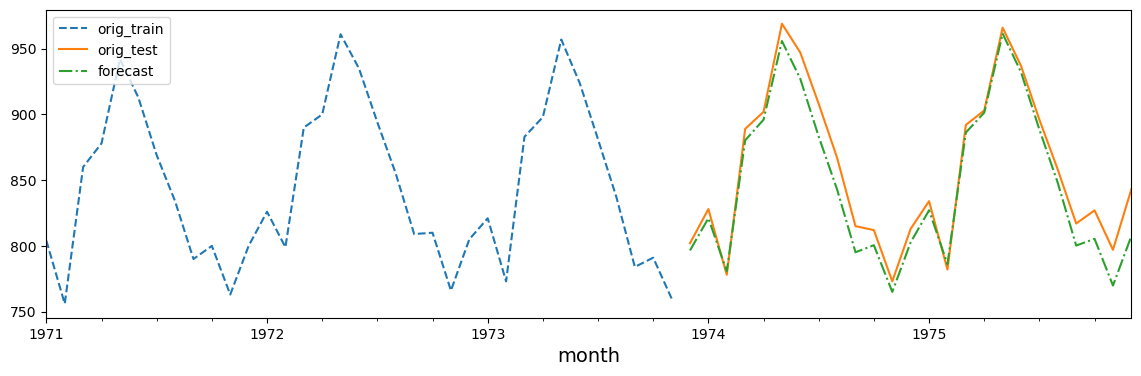

In [48]:
plot_forecast(best_model, '1971', milk_train, milk_test)
# plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)

# Advanced statistical models for Time serires

Advanced statistical techniques include auto_arima, prophet, arch

### Forecasting Time Series Data using Auto Arima

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

import matplotlib 
import statsmodels as sm
import prophet
import arch
import pmdarima
import pmdarima as pm

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
statsmodels -> {sm.__version__}
prophet -> {prophet.__version__}
arch -> {arch.__version__}
pmdarima -> {pmdarima.__version__}
''')

###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 




milk_file = r'./CodeAndDatasets/datasets/Ch11/milk_production.csv'

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)


train, test = train_test_split(milk, test_size=0.10, shuffle=False)
# same results using pmdarima
train, test = pm.model_selection.train_test_split(milk, test_size=0.10)


print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

auto_model = pm.auto_arima(train, 
                           seasonal=True, # seasonal = True looks uses SARIMA
                           m=12, # as seasonal = True, m value should be provided
                           test='adf', # detecting stationarity to determine d 
                                          # (differencing order)
                           stepwise=True) # stepwise =True -> step wise search
                                         # stepwise = false -> brute force search
                                         # random=True -> random search
auto_model.summary()


Matplotlib -> 3.5.2
pandas -> 1.4.4   
numpy -> 1.22.3
statsmodels -> 0.13.2
prophet -> 1.0
arch -> 5.3.1
pmdarima -> 1.8.5

Train: (151, 1)
Test: (17, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  151
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -475.008
Date:                            Mon, 14 Nov 2022   AIC                            956.016
Time:                                    20:14:31   BIC                            964.798
Sample:                                         0   HQIC                           959.585
                                            - 151                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2714      0.082     -3.326      0.001      -0.431      -0.111
ma.S.L12      -0.6233      0.079     -7.908      0.000      -0.778      -0.469
sigma2        54.7638      5.498      9.960      0.000      43.987      65.540
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                31.78
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.74
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
## inorder to see results in all steps we can make trace =  True
## you can also set information_criterion.
auto_model = pm.auto_arima(train, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           information_criterion='bic',
                           stepwise=True,
                           trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=982.369, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=1008.269, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=980.596, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=964.798, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=1002.362, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=969.691, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=969.676, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=980.720, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=974.652, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=970.329, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=969.593, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[12]             : BIC=969.493, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=965.218, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[12]             : BIC=974.337, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12] interc

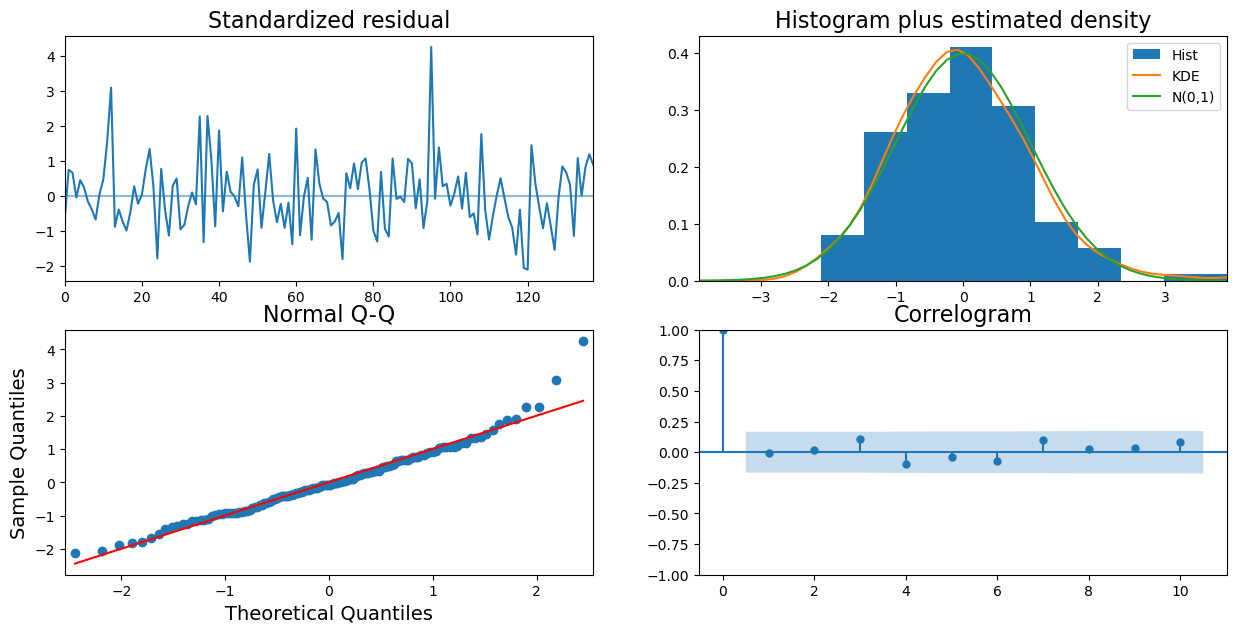

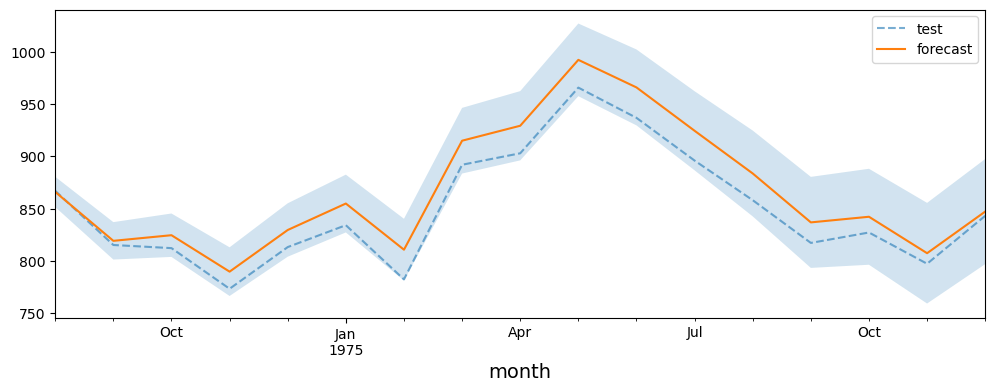

In [51]:
auto_model.plot_diagnostics(figsize=(15,7)); plt.show(); # inspect residuals

## predict using best model that stored in auto_model

n = test.shape[0]
forecast, conf_interval = auto_model.predict(n_periods=n, return_conf_int=True) 
                              ## return_conf_int = True -> returns CI values
                                 # default is 95% confidence intervals
lower_ci, upper_ci  = zip(*conf_interval)

index = test.index
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast']); plt.show()

In [52]:
### pmdarima package has many useful functions
  ## the ndiff function performs stationarity tests to determine the 
      # differencing order, d, to make the time series stationary -> adf, kpss tests
  ## the nsdiff function helps estimate the number of 
  # seasonal differencing orders (D ) that are needed -> ocsb , ch tests

from pmdarima.arima.utils import ndiffs, nsdiffs

# ADF test:
n_adf = ndiffs(milk, test='adf') 
# KPSS test (auto_arima default):
n_kpss = ndiffs(milk, test='kpss') 
# PP test:
n_pp = ndiffs(milk, test='pp')  

print(f'''
differencing (d) term using:
    ADF: {n_adf}
    KPSS: {n_kpss}
    PP: {n_pp}
''')

# OCSB test
max_D = nsdiffs(milk, test='ocsb', m=12, max_D=12) 

print(f'''
Seasonal differencing (D) term: {max_D}
''')


model = pm.auto_arima(train, 
                      seasonal=True,
                      with_intercept=True,
                      d=1,
                      max_d=2,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      m=12,
                      D=1,
                      max_D=2,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      information_criterion='aic',
                      stepwise=False,
                      out_of_sample_siz=25,
                      test = 'kpss',
                      score='mape',
                      trace=True)

                      



differencing (d) term using:
    ADF: 0
    KPSS: 1
    PP: 0


Seasonal differencing (D) term: 1

 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1007.319, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=966.470, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=968.422, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=983.036, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=968.438, Time=0.13 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=970.470, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=973.451, Time=0.25 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=968.640, Time=0.33 sec
 ARIMA(0,1,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=998.468, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=958.000, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=959.947, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=973.934, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=95

0


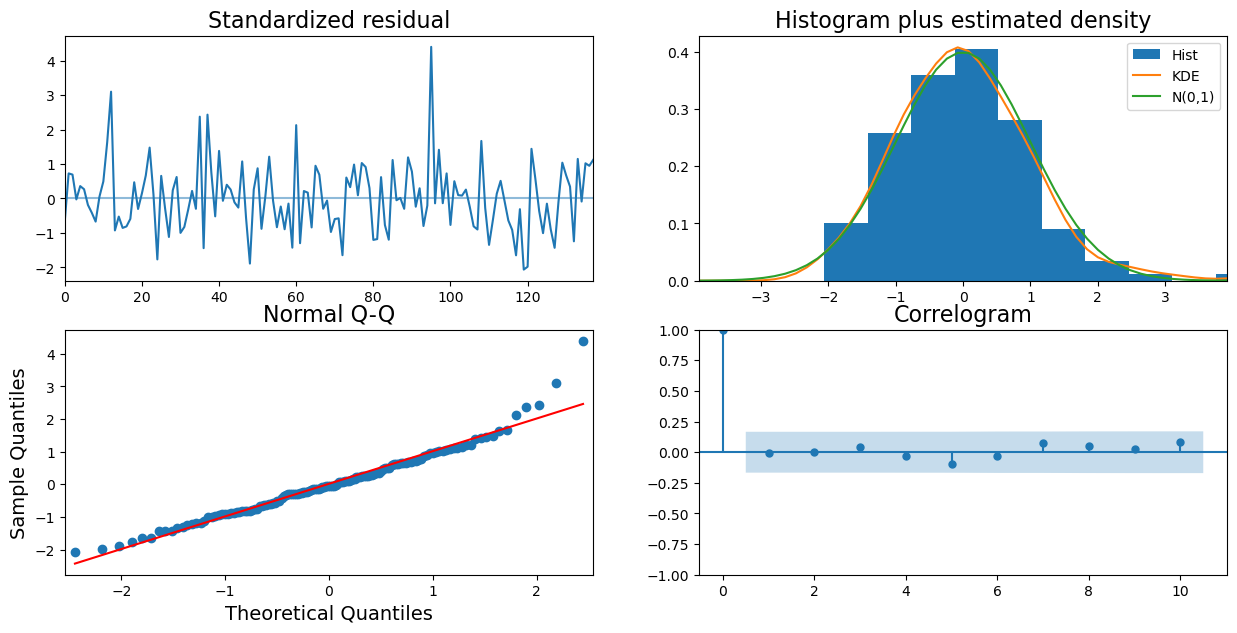

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  151
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -472.969
Date:                            Mon, 14 Nov 2022   AIC                            957.937
Time:                                    20:14:58   BIC                            975.501
Sample:                                         0   HQIC                           965.075
                                            - 151                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0460      0.621     -0.074      0.941      -1.263       1.171
ar.L1         -1.1997      0.092    -13.044      0.000      -1.380      -1.019
ar.L2         -0.3072      0.098     -3.137      0.002      -0.499      -0.115
ma.L1          0.9585      0.066     14.616      0.000       0.830       1.087
ma.S.L12      -0.6124      0.084     -7.289      0.000      -0.777      -0.448
sigma2        52.8039      5.479      9.637      0.000      42.065      63.543
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                41.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.82
Prob(H) (two-sided):                  0.41   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
print(model.out_of_sample_size)


model.plot_diagnostics(figsize=(15,7));plt.show();

model.summary()


### Forecasting Time Series Data using Prophet


Prophet provides ability to handle complex seasonality, holiday effects, missing data, and outliers etc.

Prophet algorithm is an additive Regression model that can handle non linear trends and works well with strong seasonal effects. The algorithm decomposes a time series into 3 main components: trend, seasonlaity, and holiday.

                   𝑦(𝑡) = 𝑔(𝑡) + 𝑠(𝑡) + ℎ(𝑡) + ϵt

Train: (151, 2)
Test: (17, 2)


<AxesSubplot:title={'center':'Monthly Milk Production'}, xlabel='ds'>

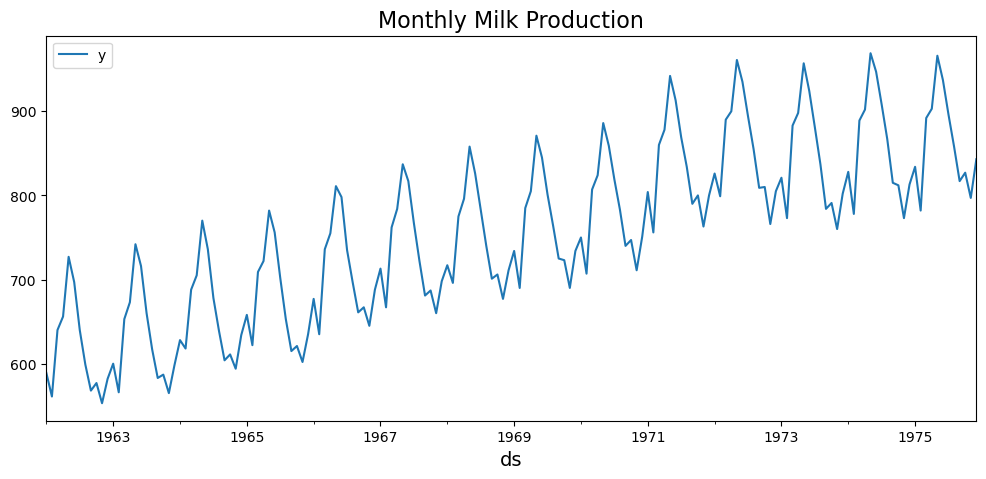

In [54]:
from prophet import Prophet

milk_file = r'./CodeAndDatasets/datasets/Ch11/milk_production.csv'
milk = pd.read_csv(milk_file, parse_dates=['month'], )
milk.columns = ['ds', 'y']


idx = round(len(milk) * 0.90)
train = milk[:idx]
test = milk[idx:]
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

milk.set_index('ds').plot(title='Monthly Milk Production')

In [55]:
model = Prophet().fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
{'additive': ['yearly', 'additive_terms', 'extra_regressors_additive', 'holidays'], 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')
         yhat    y
0  586.864878  589
1  547.508630  561
2  641.513710  640
3  659.307873  656
4  722.386081  727
           yhat    y
163  841.462907  858
164  800.403636  817
165  804.637653  827
166  773.546466  797
167  806.819372  843


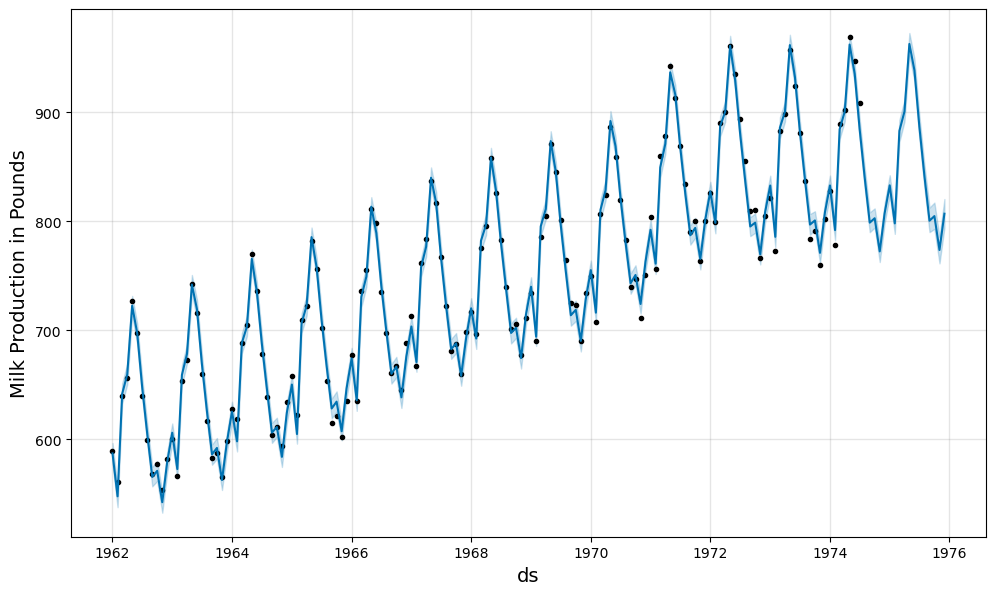

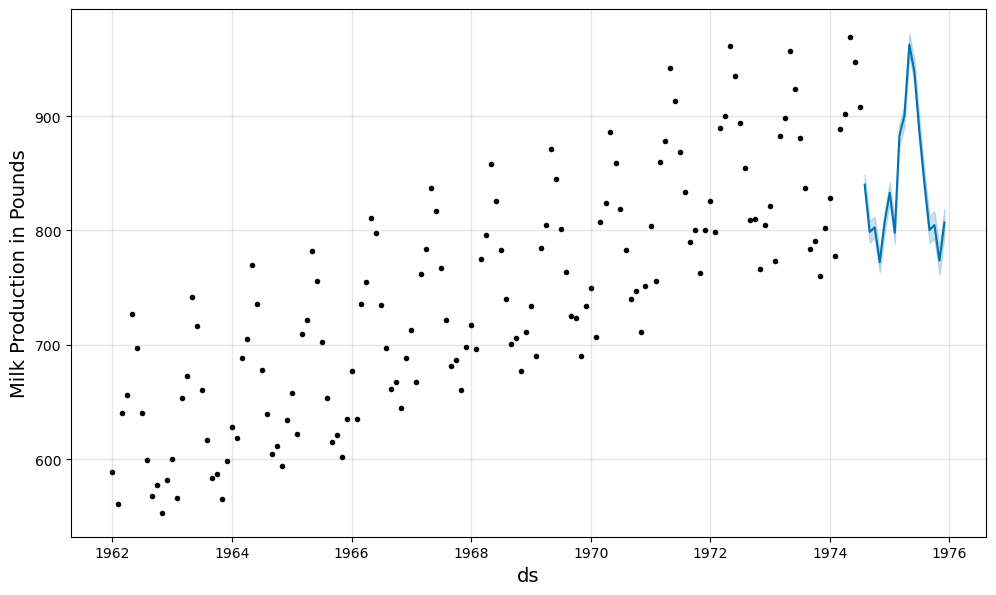

 components provide trend, seasonality and holiday (if specified) plots


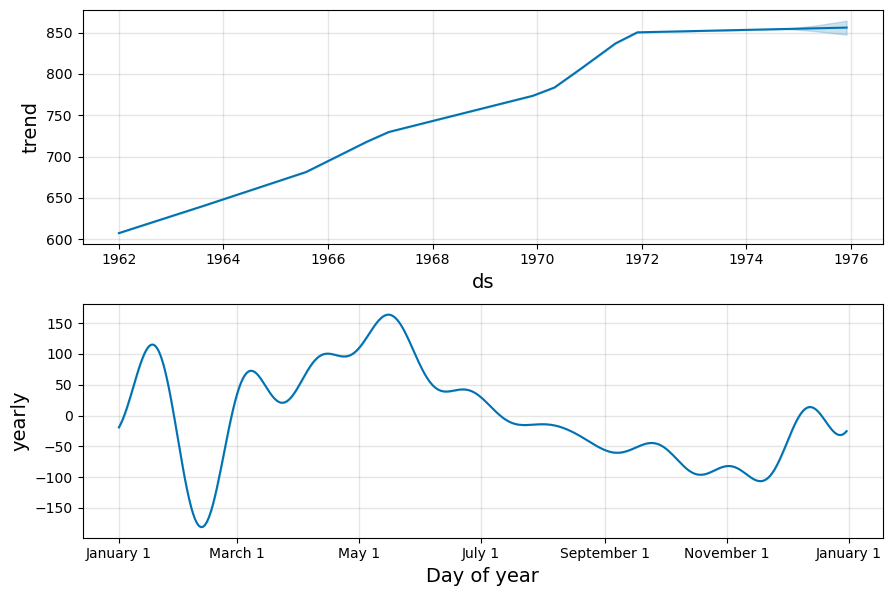

In [56]:
print(model.seasonalities)

print(model.component_modes)

future = model.make_future_dataframe(len(test), freq='MS')

forecast = model.predict(future)

print(forecast.columns)

print(pd.concat([forecast['yhat'].iloc[0:5], train['y'].iloc[0:5]], axis=1))

print(pd.concat([forecast['yhat'].iloc[-5:], test['y'].iloc[-5:]], axis=1))

model.plot(forecast, ylabel='Milk Production in Pounds') # to visualize the forecasting
plt.show();

predicted = model.predict(test)
model.plot(predicted, ylabel='Milk Production in Pounds')
plt.show();

print(' components provide trend, seasonality and holiday (if specified) plots')
model.plot_components(forecast) # plot componenets for predicted data.
plt.show();


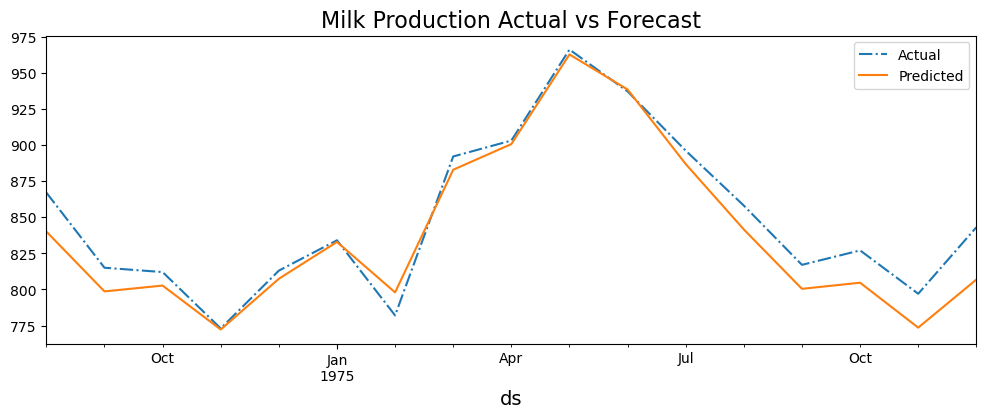

In [57]:
## compare predictions

ax = test.plot(x='ds', y='y', 
                    label='Actual', 
                    style='-.', 
                    figsize=(12,4))
predicted.plot(x='ds', y='yhat', 
               label='Predicted', 
               ax=ax)
plt.title('Milk Production Actual vs Forecast')
plt.show();

(25,)
5    1962-06-01
10   1962-11-01
14   1963-03-01
19   1963-08-01
24   1964-01-01
Name: ds, dtype: datetime64[ns]


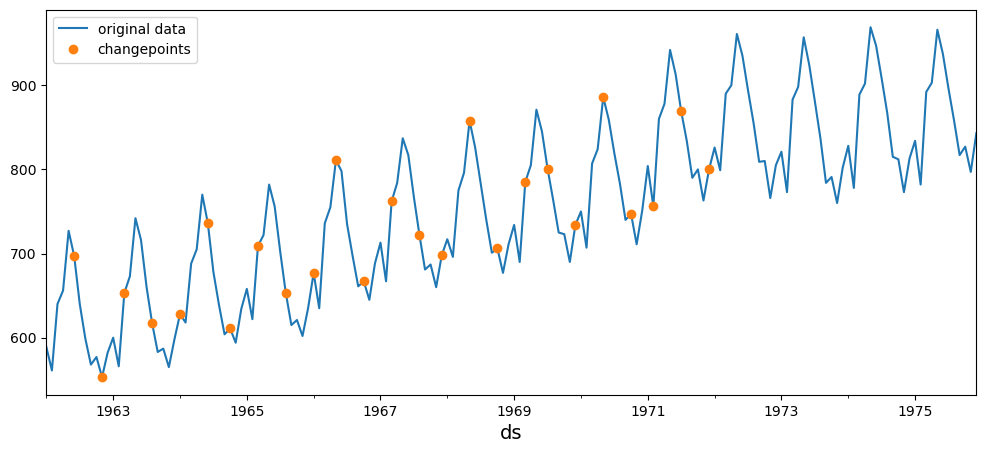

In [58]:
print(model.changepoints.shape)
print(model.changepoints.head())

ax = milk.set_index('ds').plot(figsize=(12,5))
milk.set_index('ds').loc[model.changepoints].plot(style='o', ax=ax)
plt.legend(['original data', 'changepoints'])
plt.show()

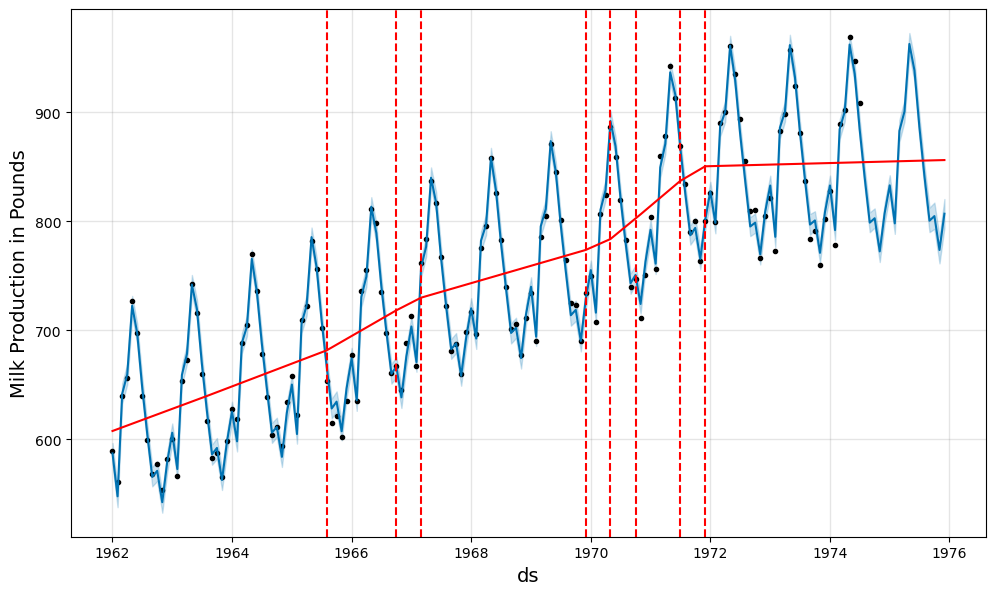

In [59]:
## pricewise regression for capturing non-linear trend
from prophet.plot import add_changepoints_to_plot

fig = model.plot(forecast, ylabel='Milk Production in Pounds')
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


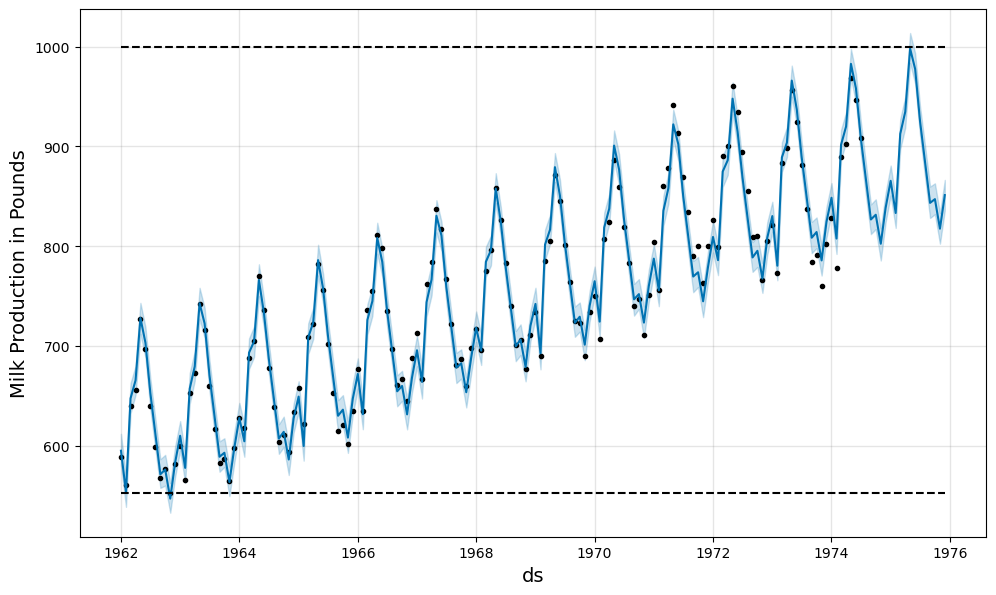

In [60]:
## Logistic growth

train['cap'] = 1000
train['floor']=train['y'].min()
model = (
        Prophet(growth='logistic')
         .fit(train)
        )

future = model.make_future_dataframe(len(test), freq='MS')
future['cap']=1000
future['floor']=train['y'].min()
forecast = model.predict(future)
model.plot(forecast, ylabel='Milk Production in Pounds')
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

### Forecasting Multivariate Time Series Data using VAR


AR, MA, ARMA, ARIMA, SARIMA are univariate one-directional timeseries models using statistical methods.

Vector Autoregressive (VAR) model is a bi-directional and multivariate.
Vector autoregressive models are very useful, especially in econometrics

VAR(p) is generalization of AR(p) for working with multiple time series.

Other forms of multivariate timeseries models include Vector Moving 
Average (VMA), Vector Autoregressive Moving Average (VARMA), and Vector 
Autoregressive Integrated Moving Average (VARIMA). all these generalize other univariate models.

Endogenous variables are influenced by other variables within the system. 
In other words, we expect that a change in one's state affects the other. Granger causality tests to determine if there is such a relationship between multiple endogenous variables.

Exogenous variables are outside the system and do not have a direct influence on the variables


**VAR(1) Formula Example**
$$
\Large y_{(1),t} = \alpha_{1} + \theta_{11}y_{(1),t-1} + \theta_{12}y_{(2), t-1} + \epsilon_{(1),t} \\\Large y_{(2),t} = \alpha_{2} + \theta_{21}y_{(1),t-1} + \theta_{22}y_{(2),t-1} + \epsilon_{(2),t} 
\\~\\
\\~\\
\Large \begin{bmatrix} y_{(1),t} \\ y_{(2),t} \end{bmatrix} =
\Large \begin{bmatrix} \alpha_{1} \\ \alpha_{2} \end{bmatrix} + \begin{bmatrix} \theta_{11} & \theta_{12} \\ \theta_{21} &  \theta_{22} \end{bmatrix}  \begin{bmatrix} y_{(1),t-1} \\ y_{(2), t-1} \end{bmatrix} + \begin{bmatrix} \epsilon_{(1),t} \\ \epsilon_{(2),t} \end{bmatrix}
$$

In [61]:
import pandas_datareader.data as web
from statsmodels.tsa.api import VAR,adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels as sm
import matplotlib as mp

start = "01-01-1990"
end = "04-01-2022"
economic_df = web.FredReader(symbols=["FEDFUNDS", 
                                      "unrate"], 
                             start=start, 
                             end=end).read()
# you can store the file for future reference (uncomment below)
# file = '../../datasets/Ch11/economic_df.pickle'
# economic_df.to_pickle(file)
# economic_df = pd.read_pickle(file)

economic_df.head()

FEDFUNDS  unrate
DATE                        
1990-01-01      8.23     5.4
1990-02-01      8.24     5.3
1990-03-01      8.28     5.2
1990-04-01      8.26     5.4
1990-05-01      8.18     5.4

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='DATE', length=388, freq='MS')
FEDFUNDS    0
unrate      0
dtype: int64
(388, 2)


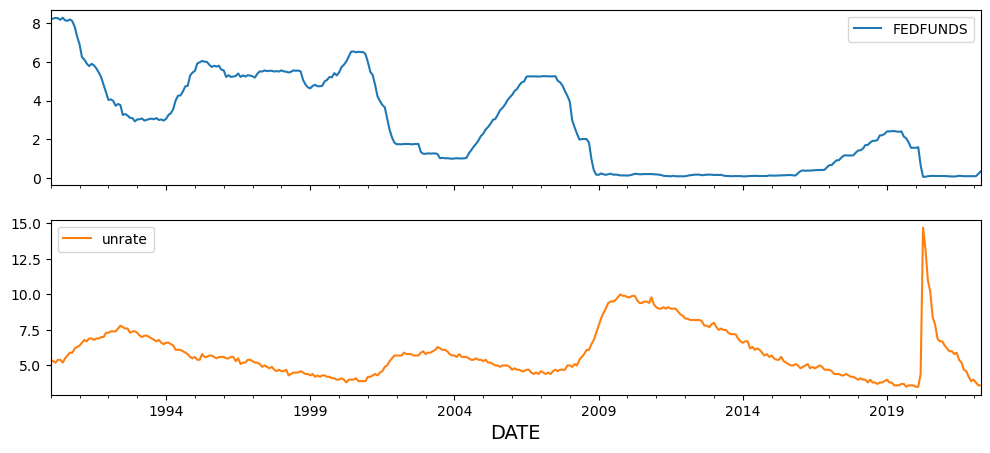

In [62]:
economic_df.index.freq = 'MS'

print(economic_df.index)

## chekcing for null values

print(economic_df.isna().sum())

print(economic_df.shape)

economic_df.plot(subplots=True); plt.show();
        # from plots it looks like there is somes sort of inverse relationship between variables

In [63]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non-stationary'
    return (kpssh, adfh)

## check for stationarity for all variables
# both endogenous variables should be stationary
for i in economic_df:
    kps, adf = check_stationarity(economic_df[i])
    print(f'{i} adf: {adf}, kpss: {kps}')
      # from adf test, both series seems to be stationary, so no need to do any 
         # stationary type tranformtions

FEDFUNDS adf: Stationary, kpss: Non-stationary
unrate adf: Stationary, kpss: Stationary



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5399  , p=0.4629  , df_denom=384, df_num=1
ssr based chi2 test:   chi2=0.5441  , p=0.4607  , df=1
likelihood ratio test: chi2=0.5437  , p=0.4609  , df=1
parameter F test:         F=0.5399  , p=0.4629  , df_denom=384, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6345 , p=0.0000  , df_denom=381, df_num=2
ssr based chi2 test:   chi2=43.8367 , p=0.0000  , df=2
likelihood ratio test: chi2=41.5213 , p=0.0000  , df=2
parameter F test:         F=21.6345 , p=0.0000  , df_denom=381, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.5541 , p=0.0000  , df_denom=378, df_num=3
ssr based chi2 test:   chi2=65.8599 , p=0.0000  , df=3
likelihood ratio test: chi2=60.7966 , p=0.0000  , df=3
parameter F test:         F=21.5541 , p=0.0000  , df_denom=378, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=16.1124 , p=0.0000  

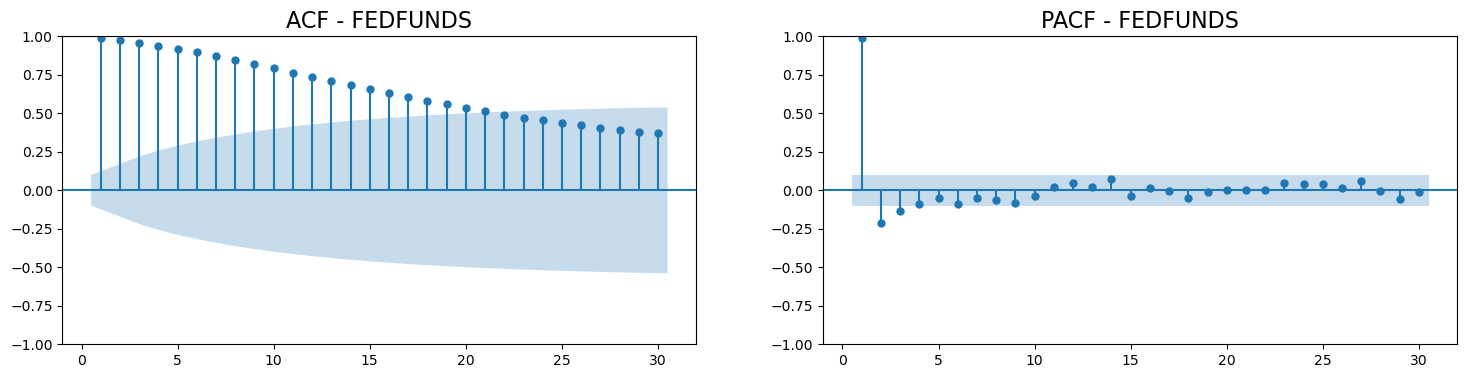

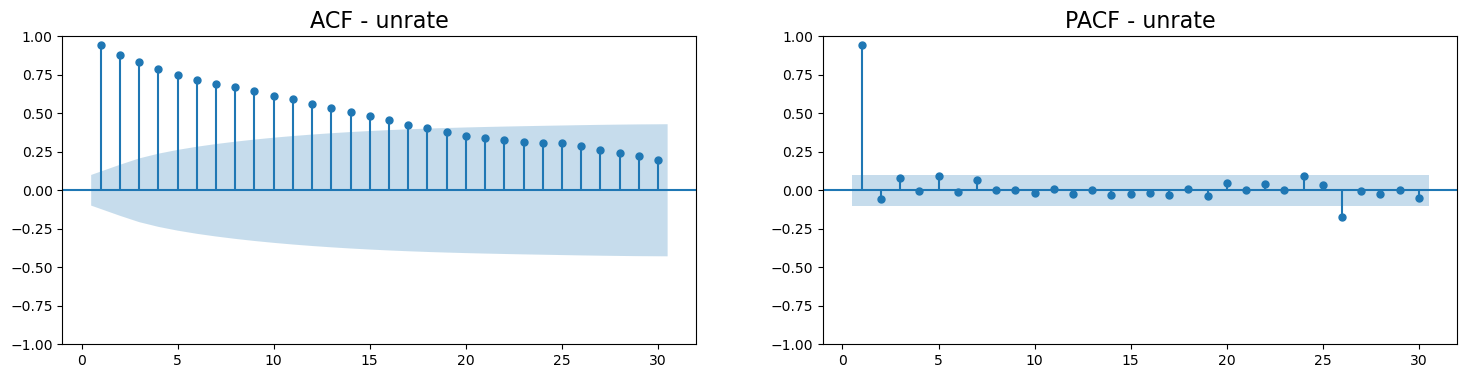

'Notice that for FEDFUNDS and unrate, the plots indicate we are dealing with an \nautoregressive (AR) process. The ACF is gradually decaying, while both PACF plots \nshow a sharp cutoff after lag 1. The PACF for FEDFUNDS shows slightly significant \n(above or below the shaded area) lags at 2 and 3, while the PACF for unrate shows \nsome significance at lag 24'

In [64]:
## check for one timeseries influences over the other using Granger casuality test

## Granger causality tests are used to determine if past values from one variable 
     # influence the other variable.
     # Null hypothesis in the Granger causality tests is that the second variable 
     # or column does not Granger cause the first variable or column. 
     # Ie. it assumes there is no statistical significance in terms of influence


granger = grangercausalitytests(economic_df[['unrate', 'FEDFUNDS']], maxlag=12)
     # except lag 1, all other lags are having p<0.05 hence they have significant
     # effect on each other

for col in economic_df.columns:
    fig, ax = plt.subplots(1,2, figsize=(18,4))
    plot_acf(economic_df[col], zero=False, 
             lags=30, ax=ax[0], title=f'ACF - {col}')
    plot_pacf(economic_df[col], zero=False, 
              lags=30, ax=ax[1], title=f'PACF - {col}');plt.show();
'''Notice that for FEDFUNDS and unrate, the plots indicate we are dealing with an 
autoregressive (AR) process. The ACF is gradually decaying, while both PACF plots 
show a sharp cutoff after lag 1. The PACF for FEDFUNDS shows slightly significant 
(above or below the shaded area) lags at 2 and 3, while the PACF for unrate shows 
some significance at lag 24'''

Train: 360, Test: 28


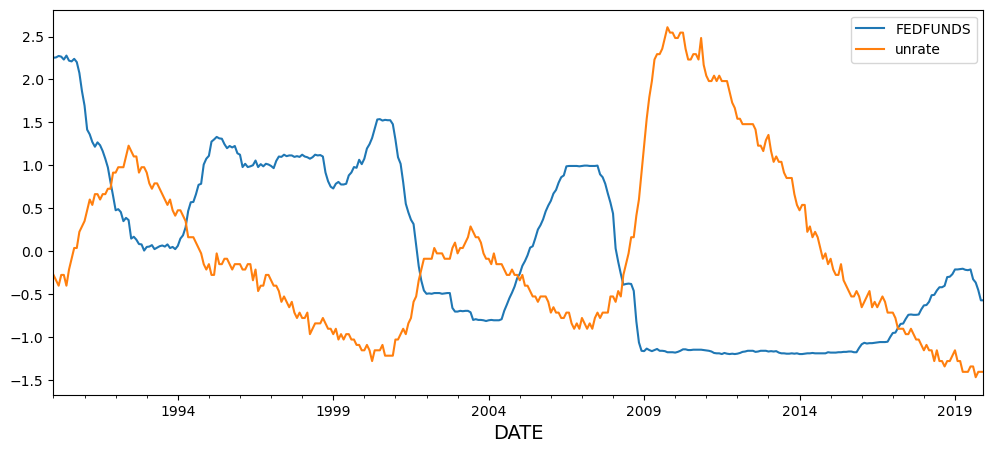

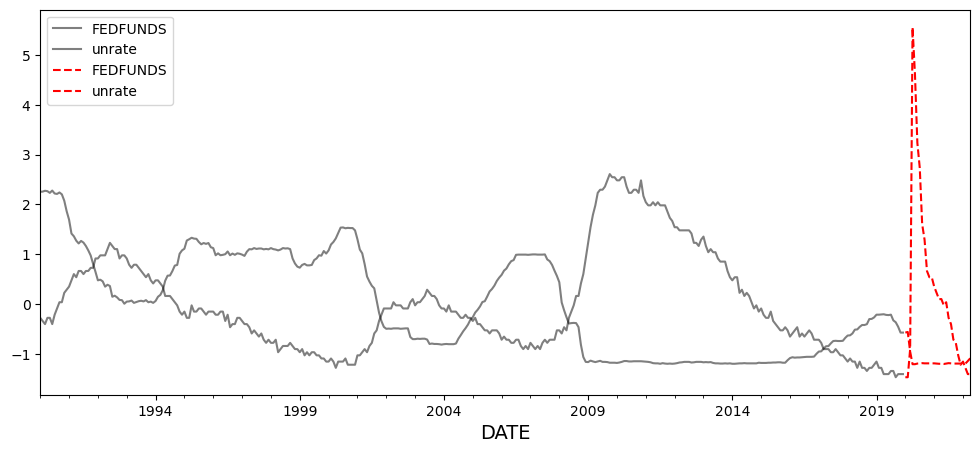

In [65]:
## do we need o standardize the variables when implementing VAR?
    # VAR Algo doesnt require the variables to be scaled.But advantage in scaling is that, 
    # coefficients can be easily compared for the variables.

# standardising the data to compare coefficients

train = economic_df.loc[:'2019']
test = economic_df.loc['2020':]

print(f'Train: {len(train)}, Test: {len(test)}')

# import standard scalar from scikit learn package

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(train)
train_sc = pd.DataFrame(scale.transform(train),
                        index=train.index,
                        columns=train.columns)
test_sc = pd.DataFrame(scale.transform(test), 
                       index=test.index,
                       columns=test.columns)


train_sc.plot();

ax = train_sc.plot(style='k', alpha=0.5, label='train')
test_sc.plot(ax=ax, style='r--', label='test')
plt.legend(); plt.show();


In [66]:
## best model can be picked up directly by specifying maxlags parameter

model = VAR(endog=train_sc)
res = model.select_order(maxlags=10)

# print select lag numbers for each score
print(res.selected_orders) # at lag 7 AIC and FPE were lowest, where as
                           # at lag 4 BIC and HQ were lowest
res.summary()

{'aic': 7, 'bic': 4, 'hqic': 4, 'fpe': 7}


<class 'statsmodels.iolib.table.SimpleTable'>

In [67]:
## train model using AIC score.

results = model.fit(maxlags=7, ic='aic')
results.summary()
    ## at the end, we can see the correlation matrix for residuals.
    # It provides insights into whether all info was captured by model
    # Ideally, we want it to be as close to zero as possible.
    # here output doesnt show a correlation, hence model is good.


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Nov, 2022
Time:                     20:15:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.3164
Nobs:                     353.000    HQIC:                  -10.5142
Log likelihood:           907.070    FPE:                2.38224e-05
AIC:                     -10.6450    Det(Omega_mle):     2.19199e-05
--------------------------------------------------------------------
Results for equation FEDFUNDS
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.002760         0.002959           -0.933           0.351
L1.FEDFUNDS         1.438184         0.053640           26.812           0.000
L1.unrate          -0.070956         0.033689           -2.106   

7


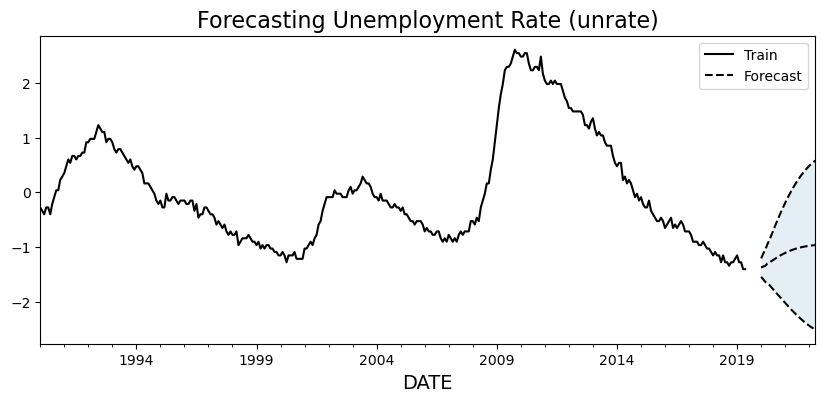

In [68]:
# store lag order parameter to use it in forcast method

lag_order = results.k_ar
print(lag_order)

past_y = train_sc[-lag_order:].values
n = test_sc.shape[0]
forecast = results.forecast_interval(past_y, n)


forecast, lower, upper = results.forecast_interval(past_y, steps=n)

idx = test.index
style = 'k--'
ax = train_sc.iloc[:-lag_order, 1].plot(figsize=(10, 4), style='k')
pred_forecast  = pd.Series(forecast[:, 1], index=idx).plot(ax=ax, style=style)
pred_lower = pd.Series(lower[:, 1], index=idx).plot(ax=ax, style=style)
pred_upper  = pd.Series(upper[:, 1], index=idx).plot(ax=ax, style=style)
plt.fill_between(idx, lower[:,1], upper[:,1], alpha=0.12)
plt.title('Forecasting Unemployment Rate (unrate)')
plt.legend(['Train','Forecast'])
plt.show();




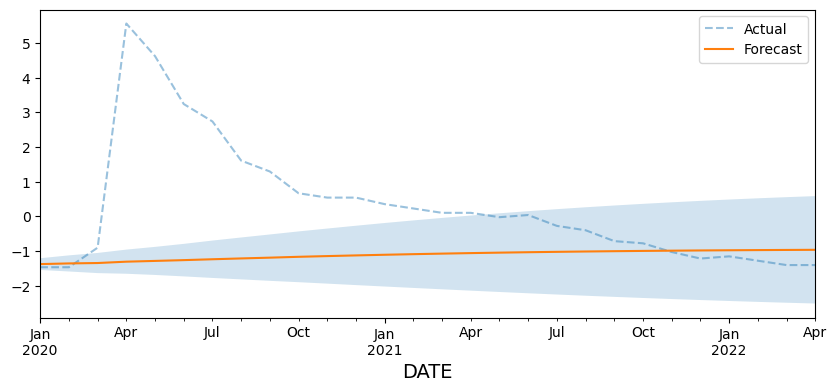

In [69]:
## compare actual and forecast

test_sc['unrate'].plot(style='--', alpha=0.45, figsize=(10, 4)).plot()
pd.Series(forecast[ :, 1], index=test_sc.index).plot()
plt.fill_between(idx, lower[:,1], upper[:,1], alpha=0.2)
plt.legend(['Actual', 'Forecast'])


In [70]:
### Lets compare VAR model with AR model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_sc['unrate'], 
              order=(lag_order,0,0)).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 unrate   No. Observations:                  360
Model:                 ARIMA(7, 0, 0)   Log Likelihood                 364.998
Date:                Mon, 14 Nov 2022   AIC                           -711.996
Time:                        20:15:06   BIC                           -677.021
Sample:                    01-01-1990   HQIC                          -698.089
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1014      0.449     -0.226      0.821      -0.982       0.779
ar.L1          0.9491      0.047     20.394      0.000       0.858       1.040
ar.L2          0.1705      0.068      2.489      0.013       0.036       0.305
ar.L3          0.0178      0.076      0.233      0.816      -0.132       0.167
ar.L4         -0.0303      0.075     -0.405      0.685      -0.177       0.116
ar.L5          0.0639      0.071      0.894      0.372      -0.076       0.204
ar.L6         -0.0134      0.075     -0.178      0.859      -0.161       0.134
ar.L7         -0.1687      0.052     -3.275      0.001      -0.270      -0.068
sigma2         0.0076      0.001     14.487      0.000       0.007       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 6.41
Prob(Q):                              0.87   Prob(JB):                         0.04
Heteroskedasticity (H):               1.15   Skew:                             0.19
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

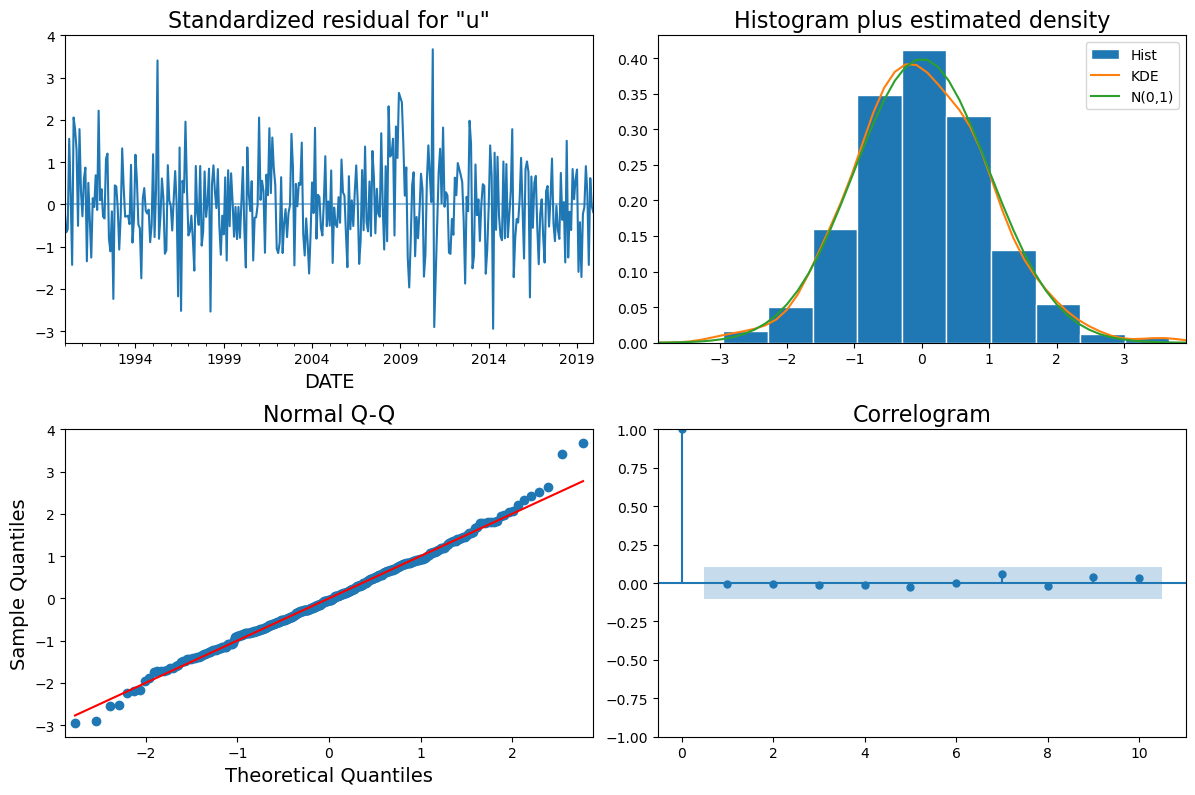

In [71]:
fig = model.plot_diagnostics(figsize=(12,8));
fig.tight_layout();plt.show()
    ## from diagnostic plots , its clear that AR model also captured info well

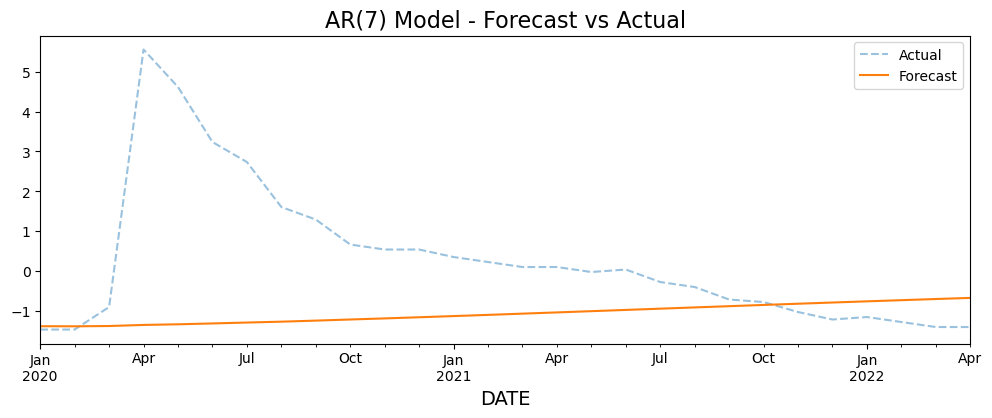

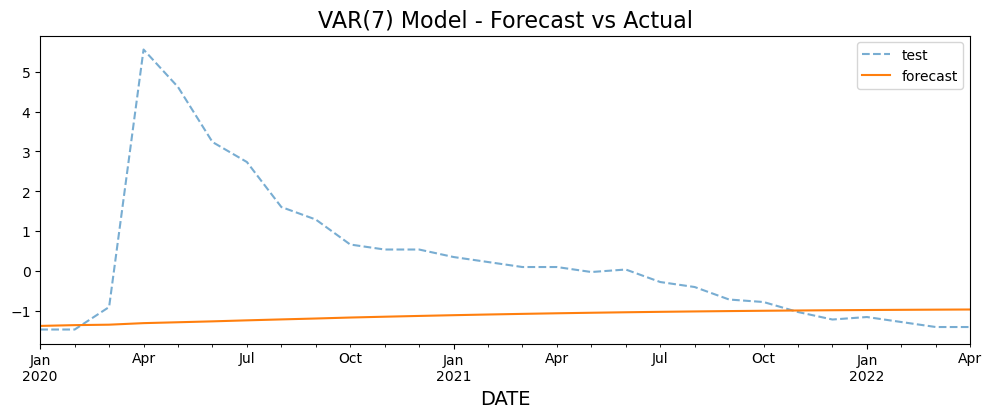

RMSE error for AR model between actual and predicted values
7.971834538644279
RMSE error for VAR model between actual and predicted values
7.951337510465982


In [72]:
## comparing results for both AR and VAR models with own predict and actual vales

# Plotting the results from an AR(7)
plt.title('AR(7) Model - Forecast vs Actual')
test_sc['unrate'].plot(style='--', alpha=0.45, figsize=(12, 4))
pd.Series(model.forecast(n), index=test_sc.index).plot()
plt.legend(['Actual', 'Forecast'])
plt.show();

index = test_sc.index
plt.title('VAR(7) Model - Forecast vs Actual')
ax = test_sc['unrate'].plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast[:, 1], index=index).plot(style='-', ax=ax)
plt.legend(['test', 'forecast']); plt.show();

print('RMSE error for AR model between actual and predicted values')
from statsmodels.tools.eval_measures import mse
rmse_ar = np.sqrt(mse(test['unrate'], forecast[:, 1]))
print(rmse_ar)
print('RMSE error for VAR model between actual and predicted values')
rmse_var = np.sqrt(mse(test['unrate'], model.forecast(n)))
print(rmse_var)

      ## both models performed similarly hence, we can choose AR model because of its simplicity


### Evaluating vector autoregressive (VAR) models

VAR model is a important step to undesrand model in terms of the interactions between the different endogenous variables.

Lets explore different diagnoistic plots like
   * Residual Autocorrelation Function (ACF)
   * Impulse Response Function (IRF)
   * Forecast Error Variance Decomposition (FEVD)



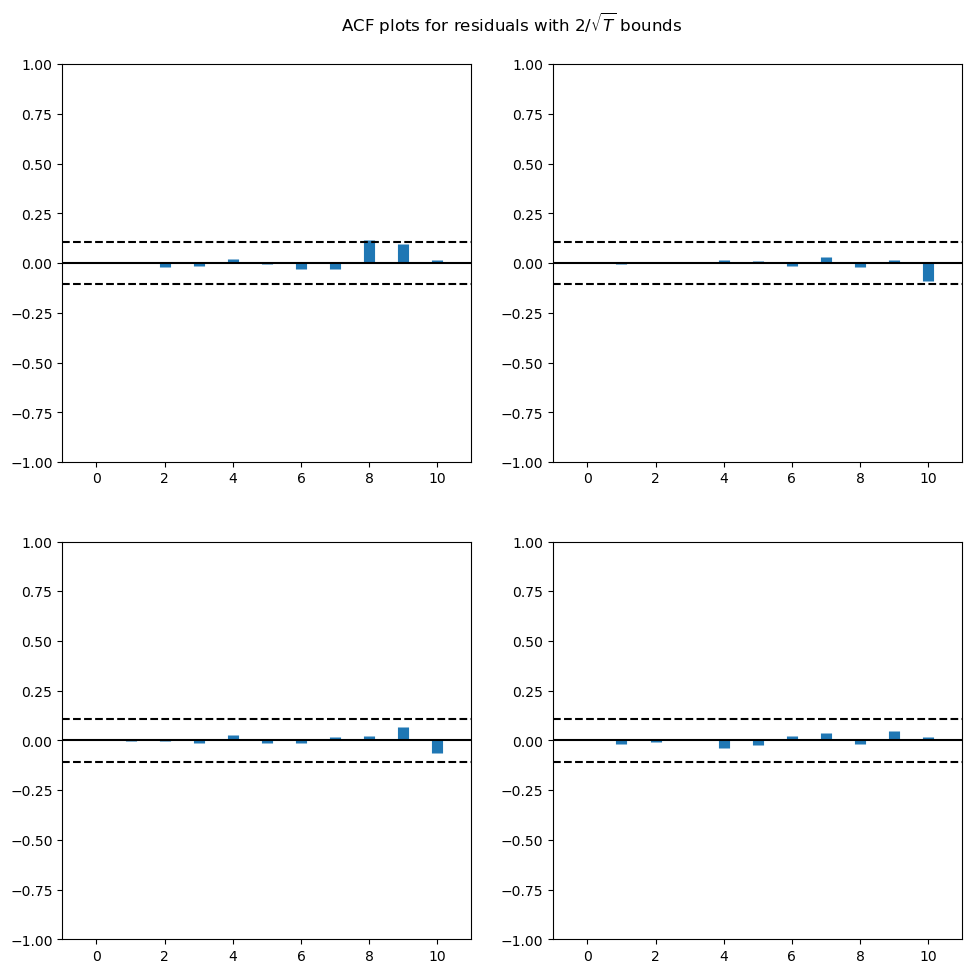

In [73]:
results.plot_acorr(resid=True);plt.show();

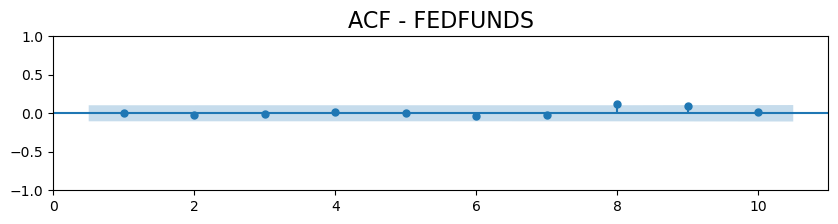

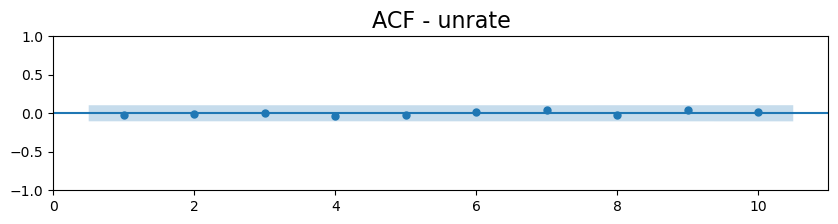

In [74]:
# You can plot your ACF on the resiuals as well using results.resid
for col in results.resid.columns:
    fig, ax = plt.subplots(1,1, figsize=(10,2))
    plot_acf(results.resid[col], zero=False, 
             lags=10, ax=ax, title=f'ACF - {col}')

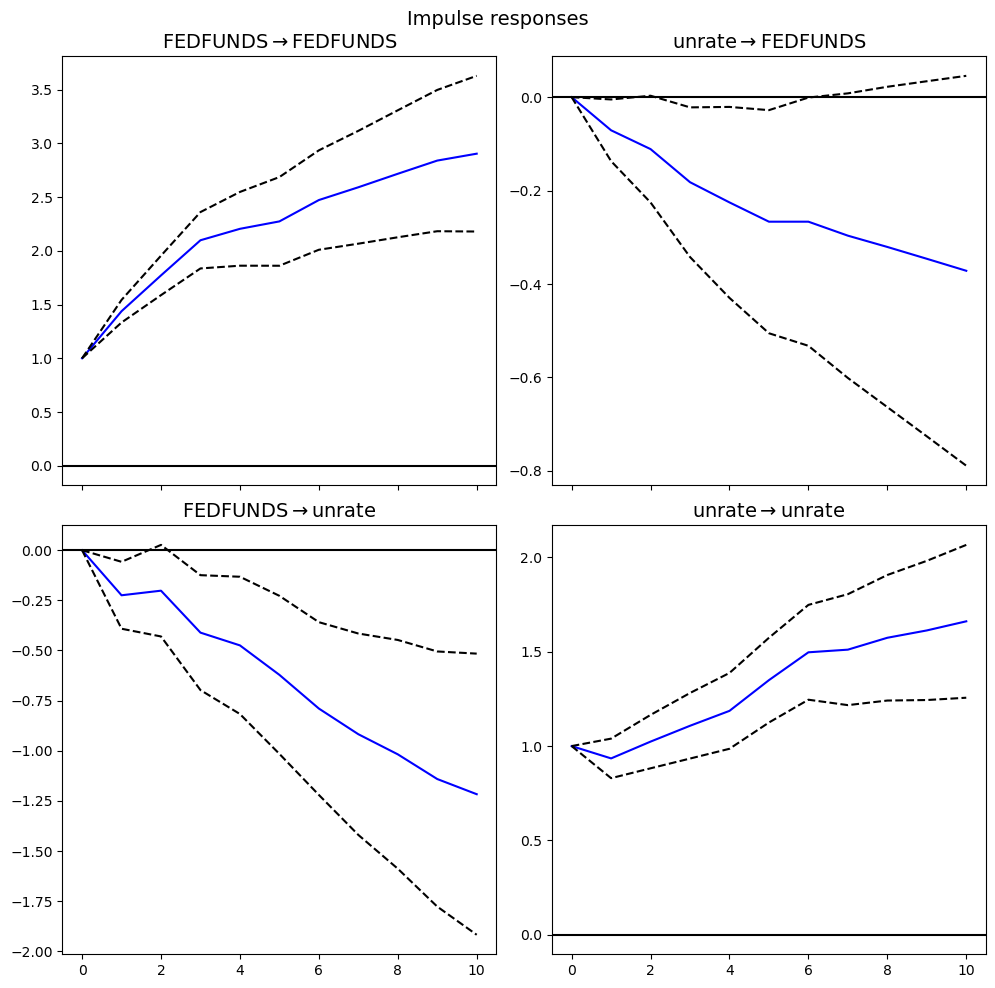

In [75]:
## Analyse impulse response to shocks in the system using irf method
irf = results.irf()
fig = irf.plot(subplot_params= {'fontsize' : 14})
fig.tight_layout();plt.show();
  ## IRF analysis computes the dynamic impulse responses and the approximated standard errors.
  # idea is that in VAR , all the variables influence each other, and 
  # impulse response (IR) traces the effect of a change in 1 variable and 
  # response from another variable over each lag.

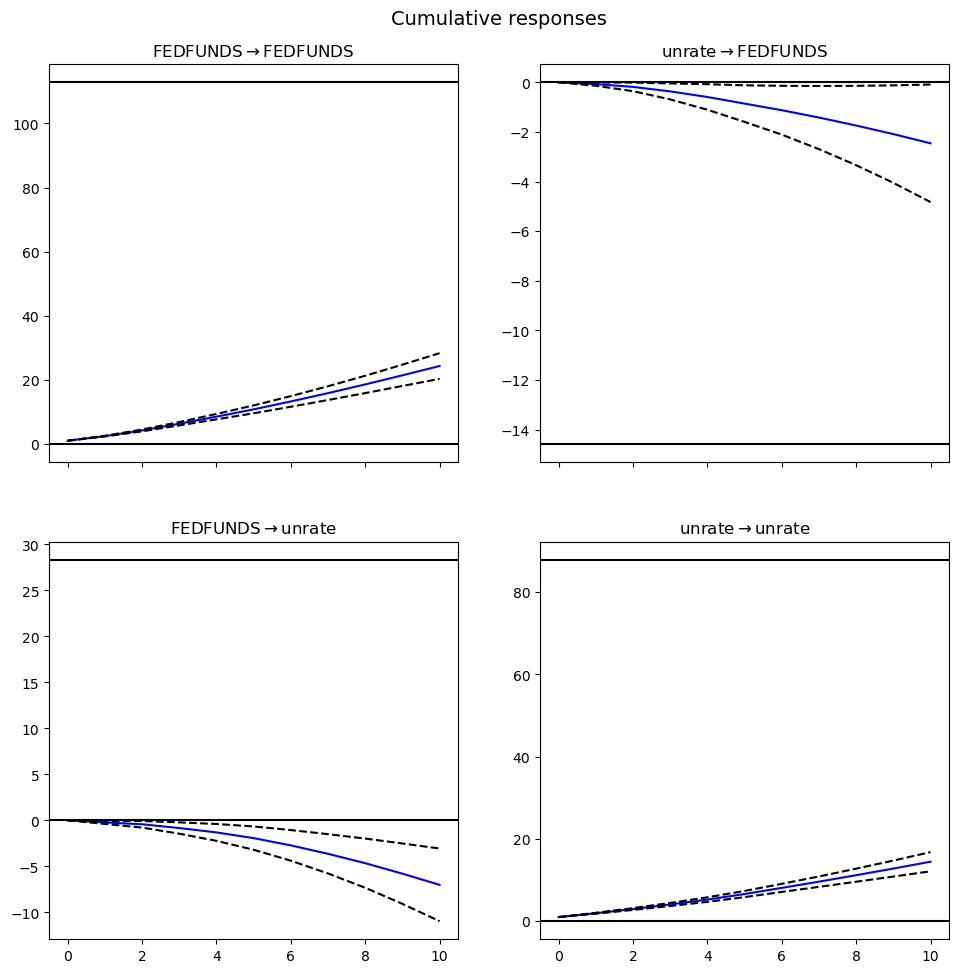

In [76]:
## plot cummulative response effect
irf.plot_cum_effects();plt.show()

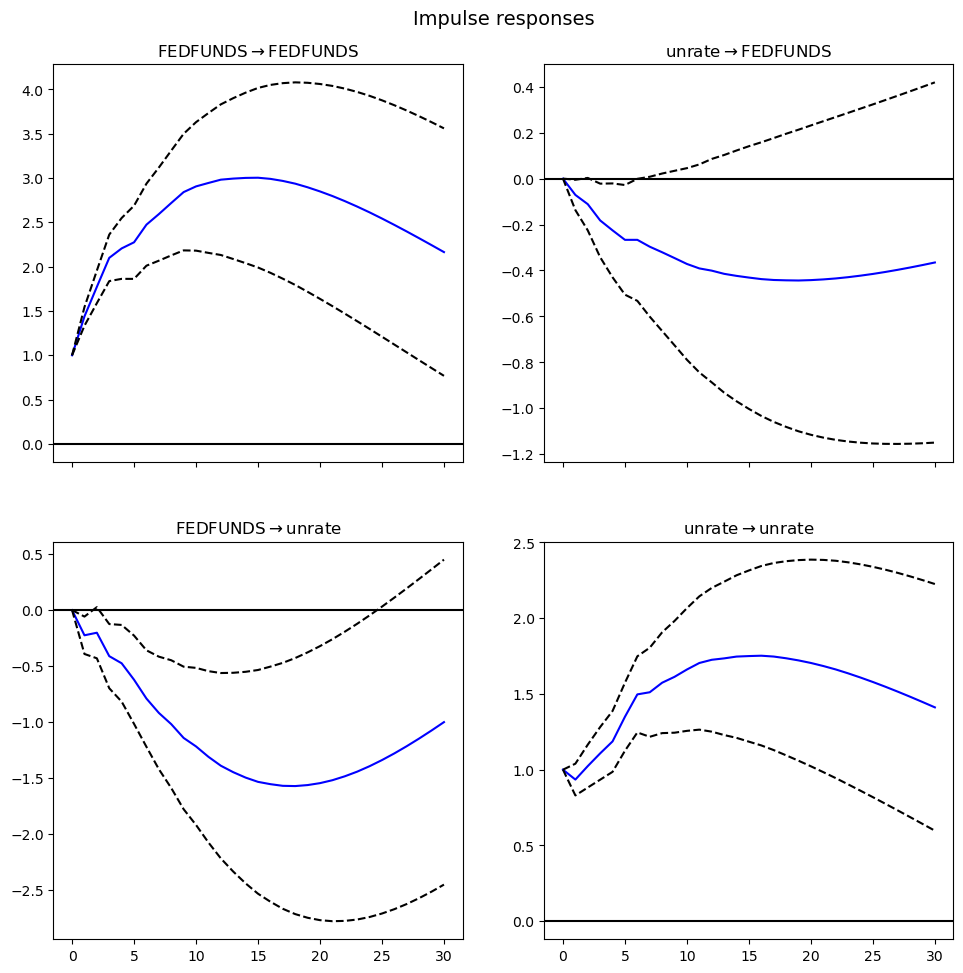

In [77]:
# Example changing lag value
irf = results.irf(30)
irf.plot();

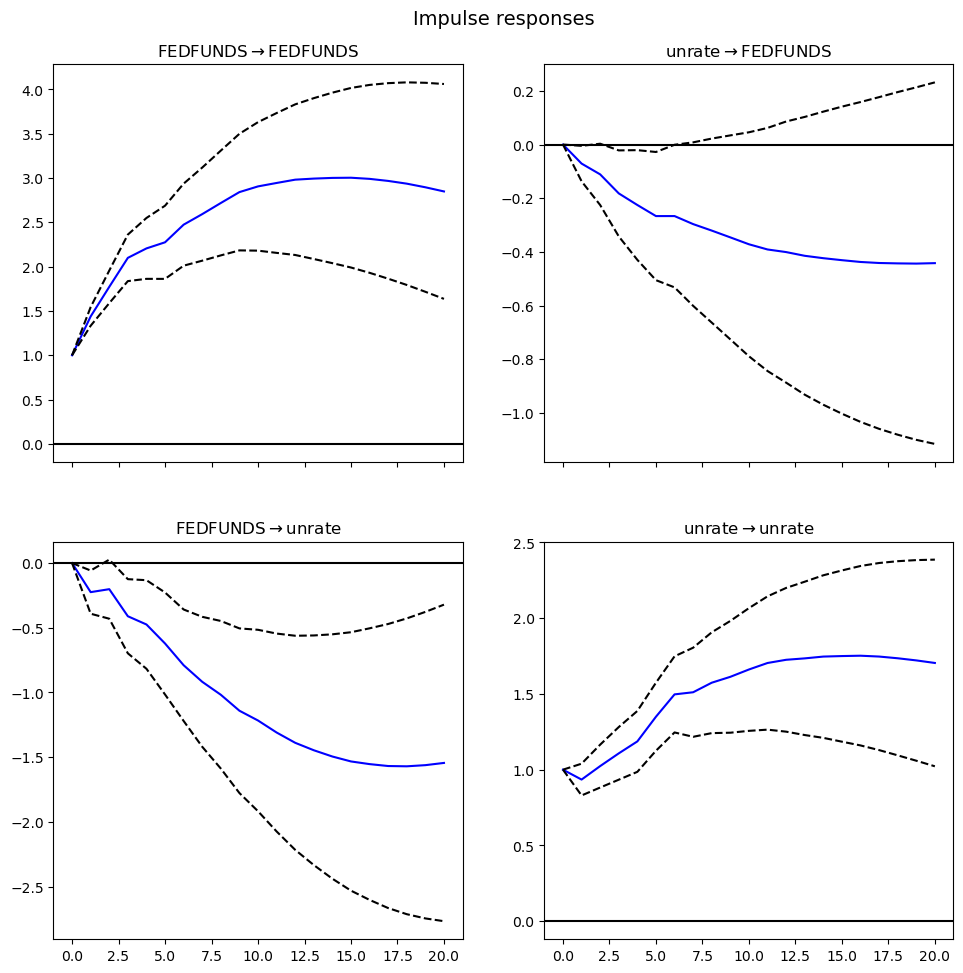

In [78]:
# Example changing lag value
irf = results.irf(20)
irf.plot();plt.show()

In [79]:
### get FEVD using fevd  -> Forecast Error variance Decomposition
fv = results.fevd()
fv.summary()

FEVD for FEDFUNDS
     FEDFUNDS    unrate
0    1.000000  0.000000
1    0.995882  0.004118
2    0.992982  0.007018
3    0.988129  0.011871
4    0.983751  0.016249
5    0.979365  0.020635
6    0.977557  0.022443
7    0.975628  0.024372
8    0.973881  0.026119
9    0.972219  0.027781

FEVD for unrate
     FEDFUNDS    unrate
0    0.000052  0.999948
1    0.009640  0.990360
2    0.011030  0.988970
3    0.022521  0.977479
4    0.031372  0.968628
5    0.042295  0.957705
6    0.055264  0.944736
7    0.069168  0.930832
8    0.081814  0.918186
9    0.094954  0.905046




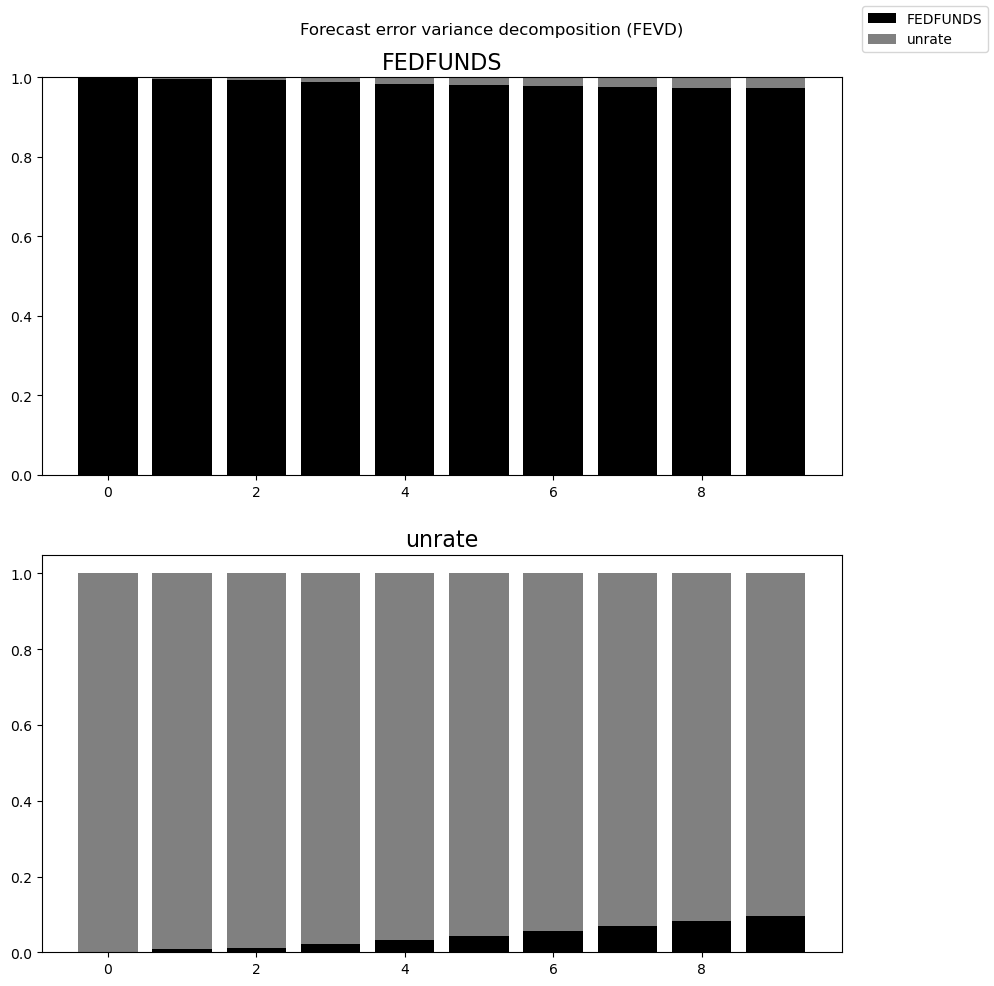

In [80]:
fv.plot(); plt.show()

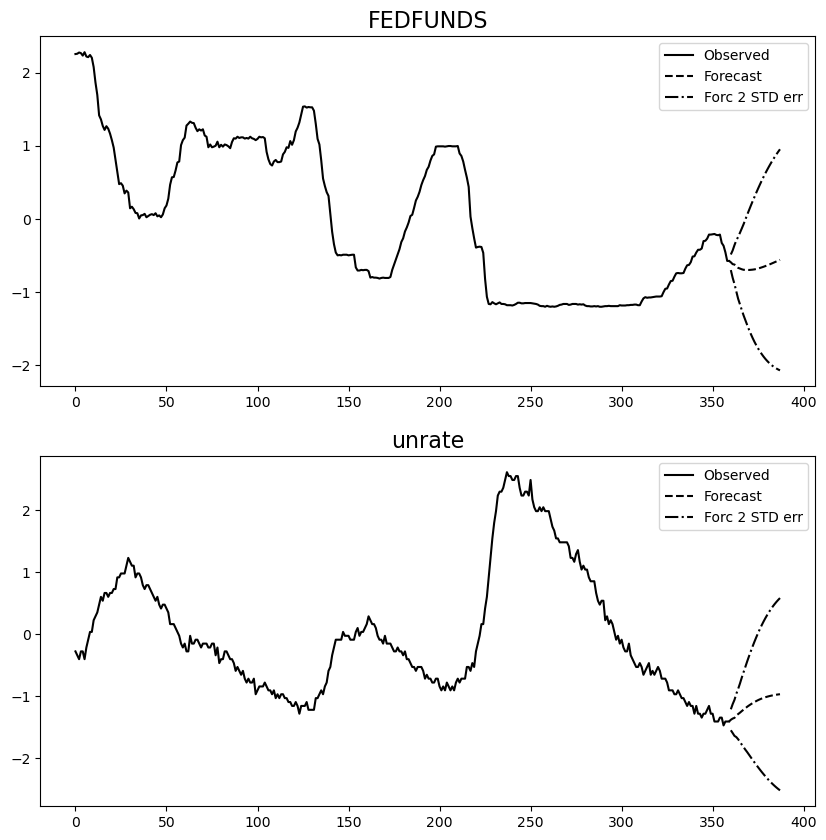

In [81]:
'''VAR implementation offers several options to help you understand the dynamics between
the different time series(or endogenous variables). It also offers diagnoistic tools to help 
you determine what adjustments need to be made to your original hypothesis'''

results.plot_forecast(n, plot_stderr=True);

### Forecasting Volatility in Financial Time Series Data with GARCH

volatility measures the spread of the probability distribution of returns and is calculated as the variance (or standard deviation) and used as a proxy for quantifying volatility or risk.

models like ARIMA, SARIMAa and prophet focuses on forecasting observed variable based on past versions of itself. These models lack modelling changes in variance over time(hetroskedasticity)

Autoregressive Conditional Hetroskedasticity(ARCH) algorithm models the change in variance over time as a function of squared error terms of timeseries.

components of ARCH models: 
• Autoregressive ->  means that the current value of a variable is 
influenced by past values of itself at different periods.
• Heteroskedasticity -> means that the model may have different magnitudes 
or variability at different time points (variance changes over time).
• Conditional, since volatility is not fixed, the reference here is on the constant that we place in the model to limit heteroskedasticity and make it conditionally 
dependent on the previous value or values of the variable.

GARCH model of order (p, q), also known as lags. q is the number of past (lag) squared residual errors ϵ2, while q is the number of past (lag) variances σ2 since variance is the square of standard deviation.

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

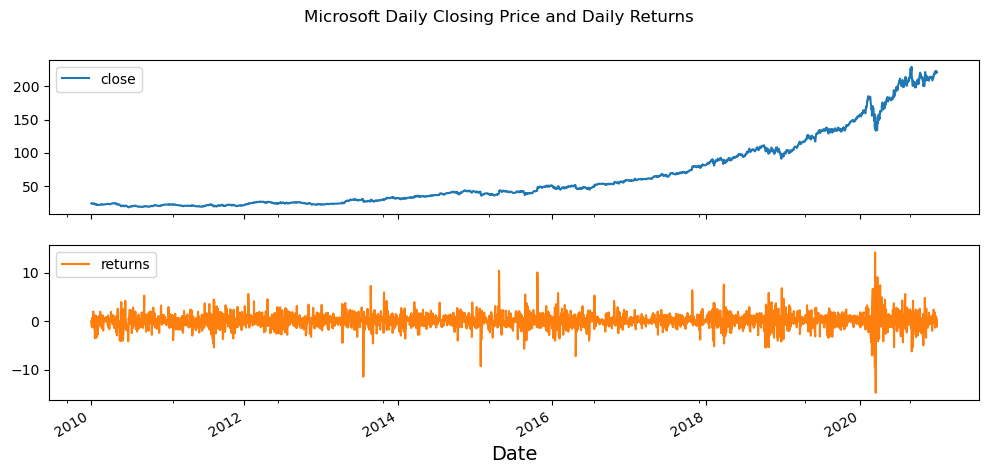

In [82]:
import arch
import pandas as pd
from arch import arch_model

msft = pd.read_csv('./CodeAndDatasets/datasets/Ch11/msft.csv', 
                   index_col='Date', 
                   parse_dates=True)
msft.head()

msft['returns'] = 100 * msft.pct_change()
msft.dropna(inplace=True, how='any')
msft.head()

msft.plot(subplots=True, 
          title='Microsoft Daily Closing Price and Daily Returns')

In [83]:
idx = round(len(msft) * 0.90)
train = msft.returns[:idx]
test = msft.returns[idx:]
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

model = arch_model(train, 
                   p=1, q=1, # simple GARCH(1, 1) model
                   mean='Constant',
                   vol='GARCH',
                   dist='normal')


results = model.fit(update_freq=5)

results.summary()

Train: (2491,)
Test: (277,)
Iteration:      5,   Func. Count:     36,   Neg. LLF: 4374.845453710037
Iteration:     10,   Func. Count:     62,   Neg. LLF: 4361.891627557763
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4361.891627557763
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4361.89
Distribution:                  Normal   AIC:                           8731.78
Method:            Maximum Likelihood   BIC:                           8755.07
                                        No. Observations:                 2491
Date:                Mon, Nov 14 2022   Df Residuals:                     2490
Time:                        20:15:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1156  2.702e-02      4.279  1.877e-05 [6.266e-02,  0.169]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3594      0.127      2.836  4.574e-03   [  0.111,  0.608]
alpha[1]       0.1458  4.424e-02      3.294  9.861e-04 [5.904e-02,  0.232]
beta[1]        0.6912  8.177e-02      8.454  2.821e-17   [  0.531,  0.852]
==========================================================================

Covariance estimator: robust
"""

$\omega$, $\alpha$ and $\beta$ are estimated by Maximum Likelihood Method

In [84]:
results.params

mu          0.115615
omega       0.359401
alpha[1]    0.145750
beta[1]     0.691248
Name: params, dtype: float64

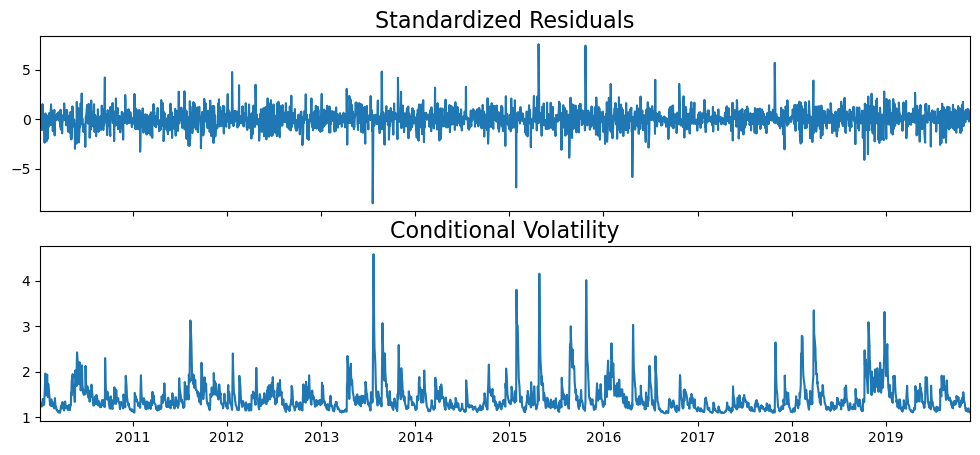

In [85]:
import matplotlib.pyplot as plt
results.plot(); plt.show();

mu          0.027019
omega       0.126747
alpha[1]    0.044241
beta[1]     0.081768
Name: std_err, dtype: float64


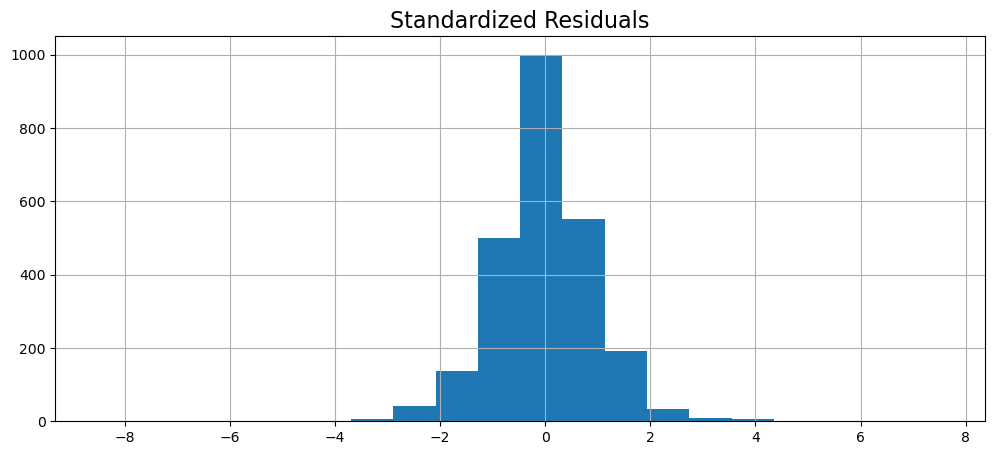

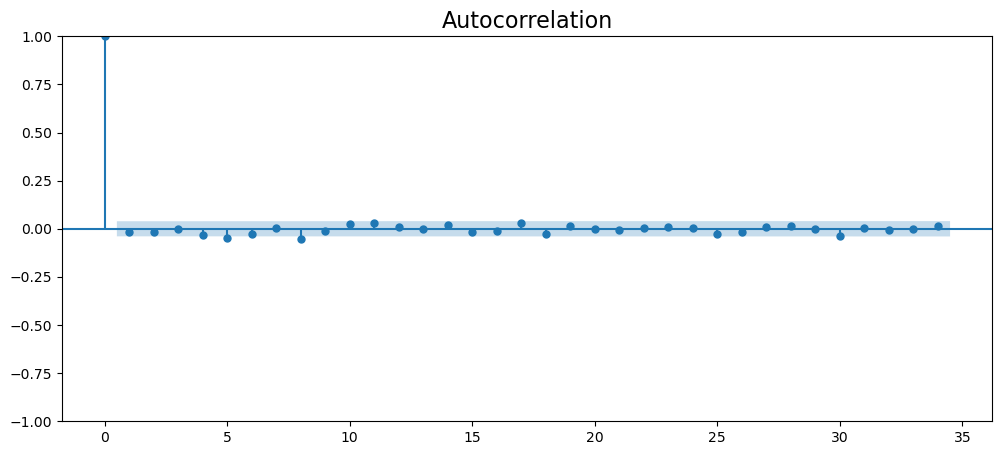

In [86]:
print(results.std_err)

## plot a histogram for the standardised residuals
results.std_resid.hist(bins=20)
plt.title('Standardized Residuals')
             ## standardised residuals are normally distributed

plot_acf(results.std_resid);plt.show();

In [87]:
## test for exisistance for auto correlation

from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(results.std_resid, 
               lags=10, 
               return_df=True)['lb_pvalue']

    ## At lags 1 to 7, we cannot reject the null hypothesis and there is 
    # no autocorrelation. Things change starting from lag 8 onward and 
    # we can reject the null hypothesis.

1     0.396521
2     0.530357
3     0.735656
4     0.473760
5     0.087968
6     0.070935
7     0.109796
8     0.017272
9     0.025041
10    0.021833
Name: lb_pvalue, dtype: float64

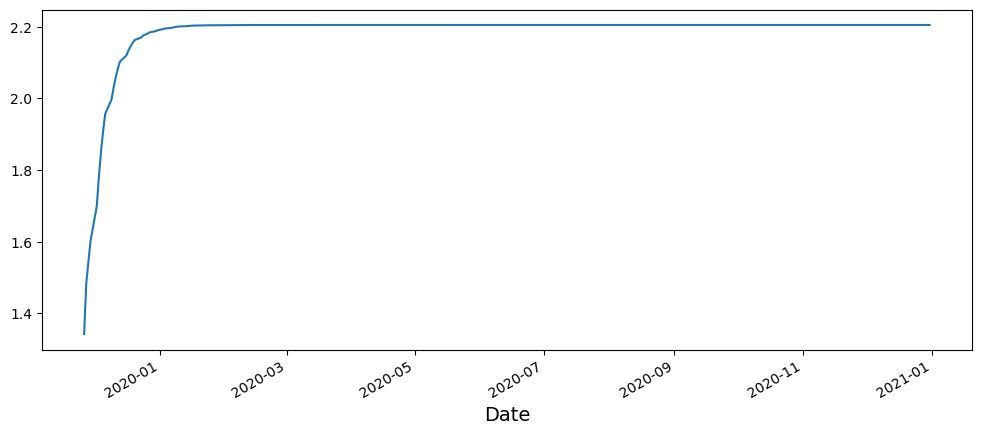

In [88]:
msft_forecast = results.forecast(horizon=test.shape[0])

forecast = msft_forecast.variance[-1:]
pd.Series(forecast.values.ravel(), index=test.index).plot();

In [89]:
### Lets implement GARCH model with mean as 0
model = arch_model(train, 
                   p=1, q=1,
                   mean='Zero',
                   vol='GARCH',
                   dist='normal')
results = model.fit(disp=False)

print(results.params)

results.summary()

omega       0.345501
alpha[1]    0.130555
beta[1]     0.711339
Name: params, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4371.30
Distribution:                  Normal   AIC:                           8748.59
Method:            Maximum Likelihood   BIC:                           8766.06
                                        No. Observations:                 2491
Date:                Mon, Nov 14 2022   Df Residuals:                     2491
Time:                        20:19:56   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3455      0.127      2.717  6.594e-03 [9.624e-02,  0.595]
alpha[1]       0.1306  3.998e-02      3.266  1.091e-03 [5.220e-02,  0.209]
beta[1]        0.7113  8.038e-02      8.850  8.787e-19   [  0.554,  0.869]
==========================================================================

Covariance estimator: robust
"""

In [90]:
msft_forecast = results.forecast(horizon=test.shape[0])
msft_forecast.mean[-1:]

h.001  h.002  h.003  h.004  h.005  h.006  h.007  h.008  h.009  \
Date                                                                        
2019-11-25    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            h.010  ...  h.268  h.269  h.270  h.271  h.272  h.273  h.274  \
Date               ...                                                    
2019-11-25    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            h.275  h.276  h.277  
Date                             
2019-11-25    0.0    0.0    0.0  

[1 rows x 277 columns]

In [91]:
### lets create GARCH mdoel with mean as Least Squares

model = arch_model(train, 
                   p=1, q=1,
                   mean='LS', lags=1,
                   vol='GARCH',
                   dist='normal')
results = model.fit(disp=False)
results.params

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Least Squares - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Least Squares   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4361.89
Distribution:                  Normal   AIC:                           8731.78
Method:            Maximum Likelihood   BIC:                           8755.07
                                        No. Observations:                 2491
Date:                Mon, Nov 14 2022   Df Residuals:                     2490
Time:                        20:21:52   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.1156  2.702e-02      4.279  1.877e-05 [6.266e-02,  0.169]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3594      0.127      2.836  4.574e-03   [  0.111,  0.608]
alpha[1]       0.1458  4.424e-02      3.294  9.861e-04 [5.904e-02,  0.232]
beta[1]        0.6912  8.177e-02      8.454  2.821e-17   [  0.531,  0.852]
==========================================================================

Covariance estimator: robust
"""

In [92]:
results.model

Least Squares(constant: yes, lags: none, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x26f7e2e2430